# Derivatives Analytics - Objects Composition

**Author**: [Gabriele Pompa](https://www.linkedin.com/in/gabrielepompa/): gabriele.pompa@unisi.com

# Table of contents

[Executive Summary](#executive-summary)

1. [Optional parameters: `*args` and `**kwargs`](#args_kwargs)\
    1.1. [Default parameters in functions](#default_func_param)\
    1.2. [Optional parameters in functions](#optional_parameters)\
    1.3. [Input flexibility](#input_flexibility)\
    1.4. [Mixing required and optional parameters](#mix_param)\
    1.5. [_Agnostic_ arguments flow](#agnostic_flow)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.5.1. [_Agnostic_ arguments flow and inheritance](#agnostic_flow_inheritance)\
&nbsp; &nbsp; &nbsp; &nbsp; 1.5.2. [_Agnostic_ arguments flow with default arguments](#agnostic_flow_default_args)\
    1.6. [Some utility functions](#utility_functions)
2. [Objects Composition](#obj_composition)\
    2.1. [A common market environment: the `MarketEnvironment` class](#MarketEnvironment)\
    2.2. [Aggregation of `EuropeanOption` with `MarketEnvironment`](#EuropeanOption_compose_MarketEnvironment)\
    2.3. [An `OptionPlotter` class to plot options](#OptionPlotter)\
    2.4. [Profit and Loss: `PnL` method](#pnl)\
&nbsp; &nbsp; &nbsp; &nbsp; 2.4.1. [_Time decay_ of option prices](#aging)\
&nbsp; &nbsp; &nbsp; &nbsp; 2.4.2. [Extending `Plotter` class to plot P&L: `getattr`](#getattr)
3. [A portfolio of options: `Portfolio` class](#portfolio)\
    3.1. [`PortfolioPlotter` from a `Plotter` base class](#plotter)
4. [Option Strategies](#opt_strat)\
    4.1. [Short positions on options](#short_positions)\
    4.2. [Bull Spread](#bull_spread)\
&nbsp; &nbsp; &nbsp; &nbsp; 4.2.1. [Digital Call Option replication using a Bull Spread Strategy](#syntetic_digital)\
    4.3. [Straddle](#straddle)\
    4.4. [Calendar Spread](#calendar_spread)

### **Resources**: 

- [_Python for Finance (2nd ed.)_](http://shop.oreilly.com/product/0636920117728.do): Chapter 6 Object-Oriented Programming.


- [Object-Oriented Programming in Python](https://python-textbok.readthedocs.io/en/1.0/index.html): From [Errors and exceptions](https://python-textbok.readthedocs.io/en/1.0/Errors_and_Exceptions.html): Errors and Handling exceptions sections. From [Functions](https://python-textbok.readthedocs.io/en/1.0/Functions.html): up to `*args` and `**kwargs` section. Section [Object-oriented programming](https://python-textbok.readthedocs.io/en/1.0/Object_Oriented_Programming.html)

# Executive Summary <a name="executive-summary"></a>

In this notebook we introduce composition which is an additional way to model relationship among objects, alternatively to inheritance. We present this relationship introducing a common market environment under which emitting options, a portfolio class under which aggregate options and another plotting application. Finally, we examine several option strategies.

The following sections are organized as follows:

- In Sec. [1](#args_kwargs) we introduce optional variable-lenght `*args` and `**kwargs` parameters which increase the flexibility of functions.
- In Sec. [2](#obj_composition) we introduce composition in Python as relationship between a common market environment `MarketEnvironment` and `EuropeanOption` class.
- In Sec. [3](#portfolio) we provide another example of composition relationship defining `Portfolio` class and plotter classes to visualize values and P&Ls.
- In Sec. [3](#opt_strat) we present several options strategies using the flexibility of the `Portfolio` class.

These are the basic imports

In [1]:
# for NumPy arrays
import numpy as np

# for Pandas Series and DataFrame
import pandas as pd

# for statistical functions
from scipy import stats

# for Matplotlib plotting
import matplotlib.pyplot as plt

# to do inline plots in the Notebook
%matplotlib inline

# for Operating System operations
import os

# for some mathematical functions
import math

# for date management
import datetime as dt

If you want to toggle line numbers of a single code cell, [press `CTRL`-`M` followed by `L`](https://stackoverflow.com/a/10986483/2533366) into that cell. If you want to toggle line numbers of all code cells of a notebook select View > Toggle Line Numbers from the options panel above (as shown in picture).

<img src="../images/toggle_line_numbers.png" width="300">

# 1. Optional parameters: `*args` and `**kwargs` <a name="args_kwargs"></a>

## 1.1. Default parameters in functions <a name="default_func_param"></a>

Before introducing optional parameters, let's recapitulate some key facts about functions in Python. Let's consider a function taking three parameters in input

In [2]:
def f(a, b, c):
    print("a={}, b={}, c={}".format(a, b, c))

In [3]:
a_0, b_0, c_0 = (1, 2, 3) # standard way to un-pack a Tuple

In [4]:
f(a_0, b_0, c_0)

a=1, b=2, c=3


Notice that all three parameters are required. If you forget one when calling the function `f()` this would cause a `TypeError`

In [5]:
# raises TypeError: f() missing 1 required positional argument: 'c'
#
# f(a_0, b_0)

In some situations we want to specify default value for a parameter. In Python this is possible by making that parameter _optional._ That is, no error is generated if we skip it and in this case it is left to its default value in function's body.

In [6]:
def f(a, b, c="c_default"):
    print("a={}, b={}, c={}".format(a, b, c))

In [7]:
f(a_0, b_0, c_0) # a value for each parameter

a=1, b=2, c=3


In [8]:
f(a_0, b_0) # no parameter 'c' in input. Parameter 'c' is left to "c_default" value in f() body

a=1, b=2, c=c_default


Rule: optional parameters (`c` in the previous example) must come _after_ all required parameters (`a` and `b` in the previous example) in function definition.

Suppose now that function `f()` has two default parameters: `b` and `c` 

In [9]:
def f(a, b="b_default", c="c_default"):
    print("a={}, b={}, c={}".format(a, b, c))

In [10]:
f(a_0, b_0, c_0) # one value for each parameter

a=1, b=2, c=3


In [11]:
f(a_0, b_0) # 'c' default

a=1, b=2, c=c_default


In [12]:
f(a_0) # 'b' and 'c' default

a=1, b=b_default, c=c_default


Question: how can we specify parameter `c` leaving parameter `b` to its default value `"b_default"`? 

In [13]:
f(a_0, c_0) # not what we intended to do...

a=1, b=3, c=c_default


Do you see the problem? Value `c_0` - that we tentatively wanted to assign to parameter `c` - is given in input to `f()` as its 2nd _positional_ parameter. Nevertheless, the 2nd position in `f`'s parameters list (aka _signature_ of `f()`) is reserved to input values to be assigned to parameter `b`, not `c`. How can we do then?

Luckily, we can pass input parameters to functions also as _keyboard_ parameters using the following syntax when calling the function

```python
function(..., parameter_name=parameter_value, ...)
```

like this

In [14]:
f(a_0, c=c_0) # 'c' as keyboard parameter, 'b' left at its default value

a=1, b=b_default, c=3


Doing this way, we successfully assigned value `c_0` to the third parameter `c`, leaving the second positional parameter `b` unspecified and thus to its defualt value `"b_default"`. Notice also that value `a_0`, passed as positional parameter, is assigned to parameter `a`. This means that we can mix positional and keyboard parameters when we call a function.

Rule: when calling a function mixing positional and keyboard parameters, keyboard parameters must come after positional parameters

In [15]:
f(a_0, b_0, c_0) # ok, all input parameters as positional parameters

a=1, b=2, c=3


In [16]:
f(a_0, b_0, c="my_c") # ok, first two parameters passed as positional parameters, third as keyboard parameters

a=1, b=2, c=my_c


In [17]:
f(a_0, b="my_b", c="my_c") # ok, first parameter passed as positional parameter, second and third as keyboard parameters

a=1, b=my_b, c=my_c


In [18]:
f(a="my_a", b="my_b", c="my_c") # ok, all input parameters as keyboard parameters

a=my_a, b=my_b, c=my_c


but if you pass a positional parameter after a keyboard parameter, this is a `SyntaxError` error

In [19]:
# SyntaxError: positional argument follows keyword argument
#
# f(a="my_a", b_0, c_0) # not ok, first parameter passed as keyboard parameters. Second (and third) as positioal

Finally, notice that when passing parameters as keyboard parameters, the order in which you input them is irrelevant

In [20]:
f(b="my_b", c="my_c", a="my_a") # order doesn't matter when passing keyboard parameters

a=my_a, b=my_b, c=my_c


## 1.2. Optional parameters in functions <a name="optional_parameters"></a>

So far, we have defined a function specifying exactly the number of parameters it expects in input. We showed how to make a parameter optional. But what if we want to have another kind of optionality: the optionality in the number of parameters in input? 

Python implements a simple way to specify _optional variable-length_ parameters in a function:

- With `*` operator before parameter name - like `*args` - you can indicate a variable-length Tuple of positional parameters. Possibly no one.

- With `**` operator before parameter name - like `**kwargs` - you can indicate a variable-length Dict of keyword parameters. Possibly no one.

Let's consider function `print_args()` which takes in input a variable-length list of positional input parameters 

In [21]:
def print_args(*args):
    for arg in args:
        print(arg)

Inside `print_args()` we access `args` as a standard Python Tuple. The `*` operator in its definition means that `print_args()` is not expecting a single `args` parameter (a Tuple), but instead a series of positional parameters 

In [22]:
a_0, b_0, c_0 = (1, 2, 3)

In [23]:
print_args(a_0, b_0, c_0)

1
2
3


In [24]:
print_args(a_0, b_0)

1
2


In [25]:
print_args(a_0)

1


In [26]:
print_args() # no input parameter at all

Let's consider function `print_kwargs()` which takes in input a variable-length list of keyboard input parameters 

In [27]:
def print_kwargs(**kwargs):
    for k, v in kwargs.items():
        print("%s: %s" % (k, v))

Inside `print_kwargs()` we access `kwargs` as a standard Python Dict. The `**` operator in its definition means that `print_kwargs()` is not expecting a single `kwargs` parameter (a Dict), but instead a series of individual keyboard parameters 

In [28]:
print_kwargs(a=a_0, b=b_0, c=c_0)

a: 1
b: 2
c: 3


In [29]:
print_kwargs(a=a_0, b=b_0)

a: 1
b: 2


In [30]:
print_kwargs(a=a_0)

a: 1


In [31]:
print_kwargs() # no input parameter at all

The naming `*args` and `**kwargs` in function definition is a convention: `*pippo` and `**pluto` would be valid names as well (but non-standard and thus discouraged). 

You can build a completely generic function `print_all()` that accepts optional parameters as positional and keyword parameters as well

In [32]:
def print_all(*args, **kwargs):
    for arg in args:
        print(arg)

    for k, v in kwargs.items():
        print("%s: %s" % (k, v))

As expected, inside `print_all()` we access `args`/`kwargs` as a series of individual positional/keyboard parameters 

In [33]:
print_all(a_0, b_0, c_0, a=a_0, b=b_0, c=c_0)

1
2
3
a: 1
b: 2
c: 3


In [34]:
print_all(c_0, a=a_0, b=b_0)

3
a: 1
b: 2


In [35]:
print_all() # no input parameter at all

In the following sections we review some common use cases of optional parameters.

## 1.3. Input flexibility <a name="input_flexibility"></a>

Optional parameters `*args` and `**kwargs` allow input flexibility. Input parameters can be either 
- a list of individual positional parameters, 
- or a list of individual keyword parameters, 
- or complete/incomplete mixtures of the two kinds

In [36]:
def f(*args, **kwargs):
    # parsing of input parameters
    a = args[0] if len(args) > 0 else kwargs['a'] if 'a' in kwargs else "a_default"
    b = args[1] if len(args) > 1 else kwargs['b'] if 'b' in kwargs else "b_default"
    c = args[2] if len(args) > 2 else kwargs['c'] if 'c' in kwargs else "c_default"
    print("a={}, b={}, c={}".format(a, b, c))

In [37]:
a_0, b_0, c_0 = (1, 2, 3) 

In [38]:
f(a_0, b_0, c_0) # order does matter: a <-- a_0, ..., c <--- c_0

a=1, b=2, c=3


In [39]:
f(c=c_0, a=a_0, b=b_0) # order doesn't matter

a=1, b=2, c=3


In [40]:
f(a_0, b_0) # 'c' not specified

a=1, b=2, c=c_default


In [41]:
f(a_0) # 'b' and 'c' not specified

a=1, b=b_default, c=c_default


In [42]:
f() # no parameters at all

a=a_default, b=b_default, c=c_default


In [43]:
f(a_0, b_0, c=c_0) # mixture of list and keyword parameters

a=1, b=2, c=3


In [44]:
f(a_0, b=b_0) # incomplete mixture of individual and keyword parameters

a=1, b=2, c=c_default


## 1.4. Mixing required and optional parameters <a name="mix_param"></a>

Mixing ordinary (required positional and default) and optional parameters is possible. 
 
In function definition, you should follow the (conventional) order:
 1. ordinary required positional parameters;
 2. ordinary default parameters;
 3. optional `*args` parameters;
 4. optional `**kwargs` parameters.
 
When calling the function, the rule is that all positional arguments (both ordinary positional and optional positional `*args` input parameters, if any) must come before all keyword arguments (both ordinary default arguments and optional `**kwargs` input parameters, if any).

In [45]:
def f(a, b="b_default", *args, **kwargs):
    """
    Parameters:
        a: ordinary positional
        b: ordinary default
        *args: optional positional
        **kwargs: optional keyword
    """
    
    print("a={}, b={}".format(a, b))
    
    for arg in args:
        print(arg)

    for k, v in kwargs.items():
        print("{}: {}".format(k, v))

In [46]:
a_0, b_0, c_0 = (1, 2, 3) # standard way to un-pack a Tuple

In this case, parameter `b` is explicitly set as the second positional argument or a keybord argument

In [47]:
f(a_0, b_0) # no additional *args or **kwargs parameter

a=1, b=2


In [48]:
f(a_0) # 'b' is default

a=1, b=b_default


In [49]:
f(a_0, b_0, c_0) # with optional positional argument

a=1, b=2
3


In [50]:
f(a_0, b_0, c=c_0) # with optional keyword argument 

a=1, b=2
c: 3


but at least `a` is required

In [51]:
# Raises: TypeError: f() missing 1 required positional argument: 'a'
#
# f() # no parameters at all

and positional arguments (neither required, nor optional) must come before keyword arguments

In [52]:
# Raises: SyntaxError: positional argument follows keyword argument
# 
# f(a=a_0, b_0) # 'b' as positional argument after 'a' as keyword argument 

In [53]:
# Raises: SyntaxError: positional argument follows keyword argument
#
# f(a_0, b=b_0, c_0) # optional positional argument after 'b' as keyword argument 

## 1.5. _Agnostic_ arguments flow <a name="agnostic_flow"></a>

_Agnostic_ arguments flow is possible when calling a `nested_func()` from an `interface_func()`: the outer function does need to access its specific parameters but doesn't need to know the details about the nested function parameters

In [54]:
def nested_func(a, b, c):
    print("In nested_func: a={}, b={}, c={}".format(a, b, c))
        
def interface_func(d, e, f, *args, **kwargs):
    # calling nested_func
    nested_func(*args, **kwargs)
    print("In interface_func: d={}, e={}, f={}".format(d, e, f))

In [55]:
a_0, b_0, c_0, d_0, e_0, f_0 = (1, 2, 3, 4, 5, 6)

In [56]:
interface_func(d_0, e_0, f_0, a_0, b_0, c_0) # order does matter: d <-- d_0, ..., c <--- c_0

In nested_func: a=1, b=2, c=3
In interface_func: d=4, e=5, f=6


In [57]:
interface_func(d=d_0, b=b_0, a=a_0, e=e_0, f=f_0, c=c_0) # order doesn't matter

In nested_func: a=1, b=2, c=3
In interface_func: d=4, e=5, f=6


### 1.5.1. _Agnostic_ arguments flow and inheritance <a name="agnostic_flow_inheritance"></a>

_Agnostic_ arguments flow smoothly generalizes to classes. When calling a `BaseClass` initializer instantiating a `DerivedClass` object, the sub-class does need to access its specific parameters but doesn't need to know the details about the parent's class parameters

In [58]:
class BaseClass:
    def __init__(self, a, b, c):
        print("In BaseClass: a={}, b={}, c={}".format(a, b, c))
        
class DerivedClass(BaseClass):
    def __init__(self, d, e, f, *args, **kwargs):    
        # calling the BaseClass initializer
        super(DerivedClass, self).__init__(*args, **kwargs)
        print("In DerivedClass: d={}, e={}, f={}".format(d, e, f))

In [59]:
a_0, b_0, c_0, d_0, e_0, f_0 = (1, 2, 3, 4, 5, 6)

In [60]:
obj = DerivedClass(d_0, e_0, f_0, a_0, b_0, c_0) # order does matter: d <-- d_0, ..., c <--- c_0

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=6


In [61]:
obj = DerivedClass(d=d_0, b=b_0, a=a_0, e=e_0, f=f_0, c=c_0) # order doesn't matter

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=6


### 1.5.2 _Agnostic_ arguments flow with default arguments <a name="agnostic_flow_default_args"></a>

The convention to put `*args` and `**kwargs` at the end of function definition should be followed whenever it's possible. Nevertheless, consider the following example that we state directly using classes (but is valid in the case of functions too). 

Suppose that the `DerivedClass` has an ordinary default parameter `f="f_default"` and its `BaseClass`, that is instantiated by the `DerivedClass` initializer, has ordinary positional arguments in its definition.

As before, you would be tempted to define this situation as follows:

In [62]:
class BaseClass:
    def __init__(self, a, b, c):
        print("In BaseClass: a={}, b={}, c={}".format(a, b, c))
        
class DerivedClass(BaseClass):
    def __init__(self, d, e, f="f_default", *args, **kwargs):    
        # calling the BaseClass initializer
        super(DerivedClass, self).__init__(*args, **kwargs)
        print("In DerivedClass: d={}, e={}, f={}".format(d, e, f))

In [63]:
a_0, b_0, c_0, d_0, e_0, f_0 = (1, 2, 3, 4, 5, 6)

As long as you want to set `f` to a specific value, it works

In [64]:
# 'f' is the third positional argument, followed by other positional arguments
obj = DerivedClass(d_0, e_0, f_0, a_0, b_0, c_0)

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=6


In [65]:
# 'f' is a keyword argument, followed by other keyword arguments
obj = DerivedClass(d_0, e_0, f=f_0, a=a_0, b=b_0, c=c_0)

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=6


But how can you specify `BaseClass`'s parameters (`a`, `b` and `c`) while leaving `DerivedClass`'s parameter `f` to its default value `"f_default"`? 

You would be tempted to omit `f` from `DerivedClass` instantiation. But if you do this:

```python
# 'f' is omitted, followed by other positional arguments
obj = DerivedClass(d_0, e_0, a_0, b_0, c_0)
```

This would raise:

```python
TypeError: __init__() missing 1 required positional argument: 'c'
```

Why? 

So, `d_0` and `e_0` values are assigned to `DerivedClass`'s parameters `d` and `e`, respectively. That's what we expected.

Nevertheless, `a_0` value is not assigned - as we intended - to `BaseClass`' parameter `a`, but in fact it gets assigned to `DerivedClass`' parameter `f` itself (which is then not left to its default value `"f_default"`). Not what we intended to do.

Indeed, we instantiate `DerivedClass` with `a_0` value as third positional argument. But the third positional parameter of `DerivedClass` initializer is reserved to the value to be assigned to parameter `f`. 

Consequently, `b_0` is assigned to `a` (in `BaseClass`) and `c_0` is assigned to `b` (in `BaseClass`).

But what value is assigned to the required `BaseClass` parameter `c`? Well, no one. Therefore, the Python interpreter thinks we forgot to input a value for the required `BaseClass`'s parameter `c` and raises the error.

What you could do is to specify the `BaseClass`' parameters as keyword parameters (using `**kwargs`)

In [66]:
# 'f' is omitted, followed by other keyword arguments
obj = DerivedClass(d_0, e_0, a=a_0, b=b_0, c=c_0)

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=f_default


but there is no way to leave `f` to default and passing `a_0, b_0, c_0` arguments as positional parameters to be assigned (using `*args`) to `BaseClass`' `a, b, c` parameters. This would make `*args` unusable. We can do better than this.

The solution is to break the convention to put `*args` (and `**kwargs`) at the end of the definition of a function. Let's switch the position of parameter `f` with that of the positional parameters `*args` (to be passed `BaseClass`) in `DerivedClass`' initializer definition. As follows:

In [67]:
class BaseClass:
    def __init__(self, a, b, c):
        print("In BaseClass: a={}, b={}, c={}".format(a, b, c))
        
class DerivedClass(BaseClass):
    def __init__(self, d, e, *args, f="f_default", **kwargs):    
        # calling the BaseClass initializer
        super(DerivedClass, self).__init__(*args, **kwargs)
        print("In DerivedClass: d={}, e={}, f={}".format(d, e, f))

There we go:

In [68]:
# 'f' is omitted, followed by other positional arguments
obj = DerivedClass(d_0, e_0, a_0, b_0, c_0)

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=f_default


In [69]:
# 'f' is omitted, followed by other keyword arguments
obj = DerivedClass(d_0, e_0, a=a_0, b=b_0, c=c_0)

In BaseClass: a=1, b=2, c=3
In DerivedClass: d=4, e=5, f=f_default


We'll see an example of this break to the convention of having `*args` and `**kwargs` to the end of a function definition when deriving the `DigitalOption` class - having a default `cash_amount=1` parameter - as a sub-class of the `EuropeanOption` base class. 

## 1.6. Some utility functions <a name="utility_functions"></a>

Before concluding this section, let's define a few utility functions that will be useful in the following.

In [70]:
def datetime_obj_to_date_string(date):
    """
    Utility function to convert: from dt.datetime object --> to 'dd-mm-YYYY' String
    """
    return date.strftime("%d-%m-%Y") if isinstance(date, dt.datetime) else date

In [71]:
def date_string_to_datetime_obj(date_string):
    """
    Utility function to convert: from 'dd-mm-YYYY' String object --> to dt.datetime
    """
    return dt.datetime.strptime(date_string, "%d-%m-%Y") if isinstance(date_string, str) else date_string

In [72]:
date_string_to_datetime_obj("15-05-2020")

datetime.datetime(2020, 5, 15, 0, 0)

In [73]:
# date_string_to_datetime_obj("a") # uncontrolled error - can be difficult to spot it when this utility function gets called under the hood

In [74]:
def test_valid_format(date_string, date_format="%d-%m-%Y"):
    """
    Utility function to test whether a date_string String in input is conform to date_format (default: 'dd-mm-YYYY') date format.
    If not raises an error.
    """
    try:
        dt.datetime.strptime(date_string, date_format)
    except ValueError:
        print("String '{}' in input is not conform to 'dd-mm-YYYY' date format".format(date_string))
        raise
    else:
        return True

Notice the use of the [`try... except` syntax](https://python-textbok.readthedocs.io/en/1.0/Errors_and_Exceptions.html#the-try-and-except-statements). This is a rather advanced topic that we just want to briefly mention here. It is used to handle possible errors (called exceptions in Python, like `TypeError`, `ValueError`, `IndexError` etc.). The syntax is the following:

```python
try:
    # do something
except ExceptionName:
    # do something else
    [raise]
[else:]
    # optionally, do something else
```

The interpreter will:
- run the code indented under the `try` statement.
- If no exception is raised, the flow of control goes to the `else` block, if present, otherwise to the next line of code;
- If an exception of the kind `ExceptionName` is raised when trying to execute the `try` block, the flow of control goes to the `except` block that gets executed. 
- If in an `except` statement there is a `raise` statement: all the code in the `except` block before the `raise` line is executed and then the `raise` statement is executed causing the program to stop with the same `ExceptionName` that was captured by the `except` clause.  
- If an exception is raised when trying to execute the `try` block - but it is not of the kind `ExceptionName` - then program crashes.

In [75]:
def date_string_to_datetime_obj(date_string):
    """
    Utility function to convert: from 'dd-mm-YYYY' String object --> to dt.datetime.
    ValueError, due to wrong date format of the input String, is controlled.
    """
    
    return dt.datetime.strptime(date_string, "%d-%m-%Y") if (isinstance(date_string, str) and test_valid_format(date_string)) \
                                                         else date_string

In [76]:
# date_string_to_datetime_obj("a") # controlled error

We want to be able to distinguish between scalar data-types, like Integers and Floats, from data-structures that we can iterate over, like Lists, NumPy's arrays, Pandas Series etc. The latter iterable data-structures are collectively identified as an `Iterable` type of data, defined in the `collections.abs` module, which we import here to be able to use it

In [77]:
from collections.abc import Iterable

In [78]:
def is_iterable(x):
    """
    Utility function to check if input can be iterated over (that is, if input is a List, np.array, pd.date_range, etc.).
    """    
    return isinstance(x, Iterable)

In [79]:
def is_iterable_not_string(x):
    """
    Utility function to check if input can be iterated over (that is, if input is a List, np.array, pd.date_range, etc.)
    but it is not a String
    """
    return is_iterable(x) and not isinstance(x, str)

In [80]:
def is_numeric(x):
    """
    Utility function to check if input is/contains numeric data.
    """
    
    if is_iterable_not_string(x):
        return isinstance(x[0], float) or isinstance(x[0], int)
    else:
        return isinstance(x, float) or isinstance(x, int)

In [81]:
def is_date(x):
    """
    Utility function to check if input is/contains date-like data.
    The error due to invalid (non 'dd-mm-YYYY') date Strings is controlled thanks to test_valid_format() function.
    """
    
    if is_iterable_not_string(x):
        return isinstance(x[0], dt.datetime) or (isinstance(x[0], str) and test_valid_format(x[0]))
    else:
        return isinstance(x, dt.datetime) or (isinstance(x, str) and test_valid_format(x))

# 2. Objects Composition <a name="obj_composition"></a>

As we have seen in the previous lesson, classes allow to organize the code into logical groups, combining data (attributes) with the functions (methods) which use those data. 

When dealing with multiple related objects, we can model their relationship too. In Python, there are two main types of relationships between objects: _composition_ and _inheritance._

We have already introduced _inheritance_ as a way to organize related objects in a hierarchical way, implementing an _"is a"_ relationship between the sub-class(es) and the base class. Nevertheless, hierarchical relationship is not the only possible kind of relationship between objects.

Another possible relationship between objects is _composition,_ which models an _"has a"_ relationship between objects. This is achieved making one object and attribute of the other. For example the relationship between a `Department` and a `Professor` can be modeled as a composition

In [82]:
class Professor:
    def __init__(self, name, surname):
        self.name = name
        self.surname = surname

class Department:
    def __init__(self, department_name, prof_obj):
        self.dept_name = department_name
        self.prof = prof_obj
    
    def printProfessor(self):
        print("Prof. {} {}".format(self.prof.name, self.prof.surname))

# make 'profFeynman' a Professor object
profFeynman = Professor(name="Richard", surname="Feynman")

# instantiating a Department object, having 'profFeynman' as .prof attribute
dept = Department(department_name="Physics", prof_obj=profFeynman)

dept.printProfessor()

Prof. Richard Feynman


Here we make a `Professor` object `profFeynman` the `.prof` attribute of `Department` object `dept` and we can access its attributes as `.prof.AttributeName`. In this way, we are modeling the situation in which the `Department` _has a_ `Professor`.

For semplicity, we have modeled the Professor-Department relationship as a 1-to-1 _composition,_ but we could easily have modeled the situation of many Professors belonging to a single Department, a 1-to-many composition relationship

In [83]:
class Professor:
    def __init__(self, name, surname):
        self.name = name
        self.surname = surname

class Department:
    def __init__(self, department_name):
        self.dept_name = department_name
        
        # initialize an empty list of Professor objects
        self.faculty = []
        
        # initialize to zero the total number of Professors
        self.faculty_size = 0
    
    def addProfessor(self, prof_obj):
        self.faculty.append(prof_obj)
        self.faculty_size += 1
    
    def printFaculty(self):
        print("There are a total of {} Professors belonging to the {} department:".format(self.faculty_size, self.dept_name))
        for prof in self.faculty:
            print("Prof. {} {}".format(prof.name, prof.surname))

# instantiating an empty Department object
dept = Department(department_name="Physics")
dept.printFaculty()

# make 'profFeynman' a Professor object
profFeynman = Professor(name="Richard", surname="Feynman")

# add 'profFeynman' Professor
dept.addProfessor(prof_obj=profFeynman)
dept.printFaculty()

# make 'profHawking' another Professor object
profHawking = Professor(name="Stephen", surname="Hawking")

# add 'profHawking' Professor
dept.addProfessor(prof_obj=profHawking)
dept.printFaculty()

There are a total of 0 Professors belonging to the Physics department:
There are a total of 1 Professors belonging to the Physics department:
Prof. Richard Feynman
There are a total of 2 Professors belonging to the Physics department:
Prof. Richard Feynman
Prof. Stephen Hawking


In general, a composition relationship can be a 1-to-1, 1-to-many or even a many-to-many relationship.

The implementation of a composition is rather broad too. Going back to the 1-Professor-to-1-Department case, for example, instead of making the whole `Professor` object an attribute of `Department`, we might have decided to parse `Professor`'s attributes (all or some of) and use them as data in `Department`

In [84]:
class Professor:
    def __init__(self, name, surname):
        self.name = name
        self.surname = surname

class Department:
    def __init__(self, department_name, prof_obj):
        self.dept_name = department_name
        self.prof_name = "Prof. {} {}".format(prof_obj.name, prof_obj.surname)
    
    def printProfessor(self):
        print(self.prof_name)

# make 'profFeynman' a Professor object
profFeynman = Professor(name="Richard", surname="Feynman")

# instantiating a Department object, having 'profFeynman' as .prof attribute
dept = Department(department_name="Physics", prof_obj=profFeynman)

dept.printProfessor()

Prof. Richard Feynman


Strictly speaking, to qualify for composition, the objects involved should be tightly related and one object should _belong_ exclusively to the other. The own existance of the _belonging_ object should be managed by the hosting object: when the hosting object ceases to exist, the belonging object should cease to exist too.

When the relationship between the two objects is still a _"has a"_ relationship, but their link is somehow weaker, we call this relationship an _aggregation._

In this notebook we shall see several forms of _composition_ / _aggregation_ - like relationships between:


- a `MarketEnvironment` class and a `EuropeanOption` class, modeling an option which is emitted under certain market circumstances (date, short-rate and underlying level);


- one (or more than one) option - either a `PlainVanillaOption` or a `DigitalOption` - and a `Portfolio` class, modeling the aggregation of securities in a portfolio;


- an `OptionPlotter` (respectively a `PortfolioPlotter`) and a plain-vanilla/digital option (respectively a portfolio of options), to cohordinate plotting functionalities with the attributes of the object to plot. 

## 2.1. A common market environment: the `MarketEnvironment` class <a name="MarketEnvironment"></a>

Let's define a common `MarketEnvironment` class which shall contain all the informations on the market circumstances under which we are going to model our derivatives. 

These market conditions are the valuation date $t$, the short-rate level $r$ (we recall that in this notebook we shall assume $r$ as the constant deterministic continuously compounded short-rate), the underlying level at emission $S_t$ and its annual volatility $\sigma$. 

In [85]:
class MarketEnvironment:
    """
    MarketEnvironment class: setting the market environment: date, underlying level, volatility level and short-rate.
    
    Attributes:
    -----------
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a dt.datetime object
        r (float):                continuously compounded short-rate;
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
    Usage: 
    --------   
        - default: MarketEnvironment() is equivalent to 
                   MarketEnvironment(t="19-04-2020", r=0.05, S_t=90.0, sigma=0.2)

        - general: MarketEnvironment(t="DD-MM-YYYY" String, r=Float, S_t=Float, sigma=Float)
    """
    
    def __init__(self, t="19-04-2020", r=0.05, S_t=90.0, sigma=0.2):
        
        print("Initializing the MarketEnvironment!")
        
        self.__t     = date_string_to_datetime_obj(t)
        self.__r     = r
        self.__S     = S_t
        self.__sigma = sigma
        
    def __repr__(self):
        return r"MarketEnvironment(t={}, r={:.1f}%, S_t={:.1f}, sigma={:.1f}%)".\
               format(self.get_t().strftime("%d-%m-%Y"), self.get_r()*100, self.get_S(), self.get_sigma()*100)

    # getters
    def get_t(self):
        return self.__t

    def get_r(self):
        return self.__r

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    # setters 
    def set_t(self, t):
        self.__t = date_string_to_datetime_obj(t)

    def set_r(self, r):
        self.__r = r

    def set_S(self, S):
        self.__S = S
        
    def set_sigma(self, sigma):
        self.__sigma = sigma

Here is a `MarketEnvironment` object

In [86]:
market_env = MarketEnvironment(t="01-06-2020", r=-0.002, S_t=10.0, sigma=0.4)
market_env

Initializing the MarketEnvironment!


MarketEnvironment(t=01-06-2020, r=-0.2%, S_t=10.0, sigma=40.0%)

or using default values for its attributes

In [87]:
market_env = MarketEnvironment()
market_env

Initializing the MarketEnvironment!


MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

## 2.2. Aggregation of `EuropeanOption` with `MarketEnvironment`  <a name="EuropeanOption_compose_MarketEnvironment"></a>

Here is our `EuropeanOption` class, composed with the `MarketEnvironment`.

In [88]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    It uses a MarketEnvironment object to define the current market conditions under which the option is modeled. 
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  Optional. Type of the option. Can be either 'call' or 'put';
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   Optional. Strike price;
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        Optional. Expiration date. Can be either a "dd-mm-YYYY" String or a dt.datetime object
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------
    
        time_to_maturity: float
            Computes the time-to-maturity of the option.
        
        parse_S_tau_parameters: float
            Parses underlying and time parameters, discribinating between time-to-maturity and valuation date
            time parameter.
    
        d1_and_d2: flaot, float
            Computes the d1 and d2 terms of Black-Scholes pricing formula
        
    Template Methods:
    --------   
    
        getters for all common attributes
        
        setters for common attributes, not belonging to mkt_env
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """

    def __init__(self, mkt_env, option_type='call', K=100.0, T="31-12-2020"):
        
        print("Initializing the EuropeanOption!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = mkt_env.get_S()
        self.__K     = K
        self.__t     = mkt_env.get_t()
        self.__T     = date_string_to_datetime_obj(T)
        self.__tau   = self.time_to_maturity()
        self.__r     = mkt_env.get_r()
        self.__sigma = mkt_env.get_sigma()
        
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau

    def get_r(self):
        return self.__r
    
    def get_sigma(self):
        return self.__sigma
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_K(self, K):
        self.__K = K
    
    def set_T(self, T):
        self.__T = date_string_to_datetime_obj(T)
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        self.__update_T()
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))
    
    # utility methods
    def time_to_maturity(self, *args, **kwargs):
        """
        Utility method to compute time-to-maturity
        """
        
        # parsing optional parameters
        t = args[0] if len(args) > 0 else kwargs['t'] if 't' in kwargs else self.get_t()
        T = args[1] if len(args) > 1 else kwargs['T'] if 'T' in kwargs else self.get_T()
        
        # convert to dt.datetime objects, if needed
        t = date_string_to_datetime_obj(t)
        T = date_string_to_datetime_obj(T)
        
        # compute and return time to maturity (in years)
        return (T-t).days / 365.0
    
    def parse_S_tau_parameters(self, *args, **kwargs):
        """
        Utility method to parse underlying and time-parameters
        """

        # underlying value 
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()

        # time parameter:
        time_param = args[1] if len(args) > 1 \
                     else kwargs['tau'] if 'tau' in kwargs \
                        else (kwargs['t'] if 't' in kwargs else None)
        
        # check that no multiple time parameters in input
        if is_iterable_not_string(time_param):
            raise NotImplementedError("No multiple time parameters allowed: {} given in input.".format(time_param))

        # time parameter interpretation according to its type        
        # case 1: no time-parameter in input
        if time_param is None:
            tau = self.get_tau()
        # case 2: valid time-to-maturity in input
        elif is_numeric(time_param):
            tau = time_param
        # case 3: valuation date in input, to be converted into time-to-maturity
        elif is_date(time_param):
            valuation_date = date_string_to_datetime_obj(time_param)
            tau = self.time_to_maturity(t=valuation_date)
        # error case: the time parameter in input has a data-type that is not recognized
        else: 
            raise TypeError("Type {} of input time parameter not recognized".format(type(time_param)))

        return S, tau
    
    # d1 and d2 terms
    def d1_and_d2(self, *args, **kwargs):
        """
        Utility method to compute d1 and d2 terms of Black-Scholes pricing formula
        """
        
        # parsing optional parameters
        S     = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau   = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
        K     = args[2] if len(args) > 2 else kwargs['K'] if 'K' in kwargs else self.get_K()
        r     = args[3] if len(args) > 3 else kwargs['r'] if 'r' in kwargs else self.get_r()
        sigma = args[4] if len(args) > 4 else kwargs['sigma'] if 'sigma' in kwargs else self.get_sigma()
            
        # compute d1 and d2
        d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)

        return d1, d2
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()

Line 53: in the initializer we parse the `mkt_env` (a `MarketEnvironment` object) and use its attributes to define those of the european option. Alternatively, we could have made the `mkt_env` object itself an attribute of `EuropeanOption`. We give default values to other parameters (option type, strike and expiration date), which are thus optional.


Line 138: function `time_to_maturity()` is made more general allowing for `*args` and `**kwargs` optional arguments.


Line 154: a new function `parse_S_tau_parameters()` is defined to parse the optional parameters (underlying and time parameter) accepted in input by the public methods (`.price()` and others) of the sub-classes `PlainVanillaOption` and `DigitalOption` (recall that sub-classes inherit methods defined in the base class). 


Line 171: thanks to the discriminant logic implemented by utility functions `is_numeric()` and `is_date()`, the time parameter in input to public sub-classes methods can be both a numeric time-to-maturity $\tau$ (Integer or Float data-type) or a valuation date $t$  (either a 'dd-mm-YYYY' date String or a `dt.datetime` object). Also, notice that these utility functions are defined outside the class but are visible inside it. Viceversa, methods defined within a class can be called outside it only using the access operator `.` on an object of that class.


Line 189: a new function `d1_and_d2()` is defined to compute $d_1$ and $d_2$ terms of Black-Scholes formula in one place. It allows for optional parameters. 

Here are our sub-classes `PlainVanillaOption` and `DigitalOption`:

In [89]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options. 
    Inherits from EuropeanOption base-class. Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
    
        public methods inherited from EuropeanOption class
    
        payoff: float
            Overridden method. Computes the payoff of the option and returns it

        price_upper_limit: float 
            Overridden method. Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Overridden method. Returns the lower limit for a vanilla option price.
            
        price: float
            Overridden method. Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: PlainVanillaOption(mkt_env) is equivalent to 
                   PlainVanillaOption(mkt_env, option_type='call', K=100.0, T="31-12-2020")

        - general: PlainVanillaOption(mkt_env, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """
    
    # initializer with optional *args and **kwargs parameters
    def __init__(self, *args, **kwargs):  
        
        # calling the EuropeanOption initializer
        super(PlainVanillaOption, self).__init__(*args, **kwargs)
        
        # info strings
        self.__info = r"Plain Vanilla {} [K={:.1f}, T={} (tau={:.2f}y)]".format(self.get_type(), self.get_K(), datetime_obj_to_date_string(self.get_T()), self.get_tau())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%, t={}]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100, datetime_obj_to_date_string(self.get_t()))
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info

    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called using (underlying), where:
        
        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
        """
        
        # underlying value 
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
                
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)
    
    def __call_payoff(self, S):
        if is_iterable(S):
            return np.array([max(0.0, s - self.get_K()) for s in S])
        else:
            return max(0.0, S - self.get_K())

    def __put_payoff(self, S):
        if is_iterable(S):
            return np.array([max(0.0, self.get_K() - s) for s in S])
        else:
            return max(0.0, self.get_K() - S)
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)

        # call case
        if self.get_type() == 'call':
            return S
        # put case
        else:
            return self.__put_price_upper_limit(S, tau)
    
    def __put_price_upper_limit(self, S, tau):
        if is_iterable(S):
            return np.repeat(self.get_K()*np.exp(-self.get_r() * tau), repeats=len(S)) 
        else:
            return self.get_K()*np.exp(-self.get_r() * tau)

    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
                                       
        # call case
        if self.get_type() == 'call':
            return self.__call_price_lower_limit(S, tau)
        # put case
        else:
            return self.__put_price_lower_limit(S, tau)

    def __call_price_lower_limit(self, S, tau):
        if is_iterable(S):
            return np.array([max(s - self.get_K()*np.exp(-self.get_r() * tau), 0.0) for s in S])
        else:
            return max(S - self.get_K()*np.exp(-self.get_r() * tau), 0.0)
                                       
    def __put_price_lower_limit(self, S, tau):
        if is_iterable(S):
            return np.array([max(self.get_K()*np.exp(-self.get_r() * tau) - s, 0.0) for s in S])
        else:
            return max(self.get_K()*np.exp(-self.get_r() * tau) - S, 0.0)
                                       
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
                       
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
               
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if is_iterable(S) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if is_iterable(S) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            K     = self.get_K()
            r     = self.get_r()
            
            # get d1 and d2 terms
            d1, d2 = self.d1_and_d2(S, tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price(S, tau) + self.get_K() * np.exp(- self.get_r() * tau) - S     

Line 44: in the initializer we make use of _agnostic_ argument passing to call the `EuropeanOption`'s initializer.

Let's make some examples:

In [90]:
Vanilla_Call = PlainVanillaOption(market_env, option_type='call', K=110.0, T="31-12-2022")
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2022, tau=2.70y, r=5.0%, sigma=20.0%)

or using default parameter values

In [91]:
Vanilla_Call = PlainVanillaOption(market_env)
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

Payoff:

In [92]:
Vanilla_Call.payoff() # using .get_S() 

0.0

In [93]:
Vanilla_Call.payoff(90) # using args[0] for S

0.0

In [94]:
Vanilla_Call.payoff(S=90) # using kwargs['S'] for S

0.0

In [95]:
Vanilla_Call.payoff([90, 100.0]) # using args[0] for S (and List in input)

array([0., 0.])

In [96]:
Vanilla_Call.payoff(S=[90, 100.0]) # using kwargs['S'] for S (and List in input) 

array([0., 0.])

Price:

In [97]:
Vanilla_Call.price() # using .get_S() and .get_tau()

3.487402470943657

In [98]:
Vanilla_Call.price(90) # using args[0] for S

3.487402470943657

In [99]:
Vanilla_Call.price(90, 0.1) # using args[0] for S and args[1] for tau

0.1434251971537872

In [100]:
Vanilla_Call.price(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.1434251971537872

In [101]:
Vanilla_Call.price(S=90, t="15-05-2020") # using kwargs['t'] for valuation date as 'dd-mm-YYYY' String

3.090131618664241

Now we can define a date (50 days after emission date $t$) as a `dt.datetime` object

In [102]:
datetime_date = Vanilla_Call.get_t() + dt.timedelta(days=50)
datetime_date

datetime.datetime(2020, 6, 8, 0, 0)

In [103]:
Vanilla_Call.price(S=90, t=datetime_date) # using kwargs['t'] for valuation date as dt.datetime object

2.718223074656688

Price upper limit:

In [104]:
Vanilla_Call.price_upper_limit() # using .get_S() and .get_tau()

90.0

In [105]:
Vanilla_Call.price_upper_limit(90) # using args[0] for S

90

In [106]:
Vanilla_Call.price_upper_limit(90, 0.1) # using args[0] for S and args[1] for tau

90

In [107]:
Vanilla_Call.price_upper_limit(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

90

In [108]:
Vanilla_Call.price_upper_limit(S=90, t="15-05-2020") # using kwargs['t'] for valuation date as 'dd-mm-YYYY' String

90

In [109]:
datetime_date = Vanilla_Call.get_t() + dt.timedelta(days=50)
datetime_date

datetime.datetime(2020, 6, 8, 0, 0)

In [110]:
Vanilla_Call.price_upper_limit(S=90, t=datetime_date) # using kwargs['t'] for valuation date as dt.datetime object

90

Price lower limit:

In [111]:
Vanilla_Call.price_lower_limit() # using .get_S() and .get_tau()

0.0

In [112]:
Vanilla_Call.price_lower_limit(90) # using args[0] for S

0.0

In [113]:
Vanilla_Call.price_lower_limit(90, 0.1) # using args[0] for S and args[1] for tau

0.0

In [114]:
Vanilla_Call.price_lower_limit(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.0

In [115]:
Vanilla_Call.price_lower_limit(S=90, t="15-05-2020") # using kwargs['t'] for valuation date as 'dd-mm-YYYY' String

0.0

In [116]:
datetime_date = Vanilla_Call.get_t() + dt.timedelta(days=50)
datetime_date

datetime.datetime(2020, 6, 8, 0, 0)

In [117]:
Vanilla_Call.price_lower_limit(S=90, t=datetime_date) # using kwargs['t'] for valuation date as dt.datetime object

0.0

The same can be done in the put case

In [118]:
Vanilla_Put = PlainVanillaOption(market_env, option_type='put')
Vanilla_Put

Initializing the EuropeanOption!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [119]:
Vanilla_Put.payoff() # using .get_S() 

10.0

In [120]:
Vanilla_Put.price(S=90, t="15-05-2020") # using kwargs['t'] for valuation date as 'dd-mm-YYYY' String

9.988563573875197

etc.

Here is our `DigitalOption` sub-class

In [121]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Inherits from EuropeanOption base-class. Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        Q (float):                   cash amount
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   

        public methods inherited from EuropeanOption class

        payoff: float
            Overridden method. Computes the payoff of the option and returns it

        price_upper_limit: float 
            Overridden method. Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Overridden method. Returns the lower limit for a vanilla option price.
            
        price: float
            Overridden method. Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: DigitalOption(mkt_env) is equivalent to 
                   DigitalOption(mkt_env, cash_amount=1.0, option_type='call', K=100.0, T="31-12-2020")

        - general: DigitalOption(mkt_env, cash_amount=Float, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """

    # initializer with optional *args and **kwargs parameters and default cash_amount
    # default keyword arguments (like cash_amount here) must go after args list argument in function def
    def __init__(self, *args, cash_amount=1.0, **kwargs):  
        
        # calling the EuropeanOption initializer
        super(DigitalOption, self).__init__(*args, **kwargs)
        
        # amount of cash in case of payment
        self.__Q = cash_amount    
        
        # info strings
        self.__info = r"CON {} [K={:.1f}, T={} (tau={:.2f}y), Q={:.1f}]".format(self.get_type(), self.get_K(), datetime_obj_to_date_string(self.get_T()), self.get_tau(), self.get_Q())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%, t={}]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100, datetime_obj_to_date_string(self.get_t()))

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_Q(self):
        return self.__Q
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called using (underlying), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
        """
        
        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
        
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)

    def __call_payoff(self, S):
        if is_iterable(S):
            return np.array([self.get_Q() * int(s > self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S > self.get_K())

    def __put_payoff(self, S):
        if is_iterable(S):
            return np.array([self.get_Q() * int(s <= self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S <= self.get_K())
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
            
        # the same for call and put
        return self.__price_upper_limit(S, tau)
 
    def __price_upper_limit(self, S, tau):
        if is_iterable(S):
            return np.repeat(self.get_Q()*np.exp(-self.get_r() * tau), repeats=len(S))
        else:
            return self.get_Q()*np.exp(-self.get_r() * tau)
                                       
    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called using (underlying), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers            
        """

        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
            
        # call case
        if self.get_type() == 'call':
            return np.repeat(0.0, repeats=len(S)) if is_iterable(S) else 0.0
        # put case
        else:
            return np.repeat(0.0, repeats=len(S)) if is_iterable(S) else 0.0
        
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
                       
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
            
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if is_iterable(S) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if is_iterable(S) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
                
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            Q = self.get_Q()
            r = self.get_r()
            
            # get d2 term
            _, d2 = self.d1_and_d2(S, tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * tau) - self.__call_price(S, tau)        

Line 46: in the initializer we make use of _agnostic_ argument passing to call the `EuropeanOption`'s initializer. Notice also that default parameter `cash_amount = 1.0` goes after optional positional parameters `*args` (see Section [1.3.1](#agnostic_flow_default_args) for discussion)

The instantiation of a `DigitalOption` object and the calling of its public methods is analogous to the `PlainVanillaOption` case

If you want to set the cash amount

In [122]:
CON_Call = DigitalOption(market_env, cash_amount=1000.0)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1000.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

Or just the other `EuropeanOption`'s attributes

In [123]:
CON_Call = DigitalOption(market_env, option_type='call', K=110.0, T="31-12-2022")
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2022, tau=2.70y, r=5.0%, sigma=20.0%)

Or setting everything

In [124]:
CON_Call = DigitalOption(market_env, cash_amount=1000.0, option_type='call', K=110.0, T="31-12-2022")
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1000.0, S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2022, tau=2.70y, r=5.0%, sigma=20.0%)

Or leaving all attributes to the default value

In [125]:
CON_Call = DigitalOption(market_env)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

Here is some method's example

In [126]:
CON_Call.payoff() # using .get_S() 

0.0

In [127]:
CON_Call.price(S=90, t="15-05-2020") # using kwargs['t'] for valuation date as 'dd-mm-YYYY' String

0.2839379657620807

Analogously in the put case

In [128]:
CON_Put = DigitalOption(market_env, option_type='put')
CON_Put

Initializing the EuropeanOption!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [129]:
CON_Put.payoff() # using .get_S() 

1.0

In [130]:
CON_Put.price(S=90, t="15-05-2020") # using kwargs['t'] for valuation date as 'dd-mm-YYYY' String

0.6850463537900289

etc.

## 2.3. An `OptionPlotter` class to plot options  <a name="OptionPlotter"></a>

Let's now cohordinate the single- and multi-time plotting functions (*) in an `OptionPlotter` plotter class. 


(*) single- and multi-time plotting function used to be called `plot_single_tau()` and `plot_multi_tau()` functions in previous notebooks. Now we change their naming into `.__plot_single_time()` and `.__plot_multi_time()` (private) methods since now the time parameter can be either a time-to-maturity $\tau$ or a valuation date $t$. 

We _compose_ the `OptionPlotter` plotter class with a `FinancialInstrument` object which is expected to be either a plain-vanilla (`PlainVanillaOption` object) or a digital (`DigitalOption` object) option object.

In [131]:
class OptionPlotter:
    """
    Plotter class to plot the price of options. It implements a composition with an underlying `FinancialInstrument` 
    object to access option-specific attributes.
    
    Attributes:
    -----------
        FinancialInstrument (PlainVanillaOption or DigitalOption):    Instance of an EuropeanOption sub-class
        x_axis (np.ndarray):                                          An array representing the x-axis of the plot.
        time_parameter (single or Iterable date or time-to-maturity): A single value or Iterable object representing the
                                                                      time(s)-to-maturity or valuation date(s) at which the
                                                                      plot has to be made.
        title_label (String):                                         String representing the plot title. From .get_info()
                                                                      and .get_mkt_info() of FinancialInstrument.
    
    Public Methods:
    --------   
    
        getters for all attributes
        
        x_axis and time_parameter utility functions

        time_parameter utility method to discriminate between single or Iterable time_parameter.
        
        parse_plot_details utility method to parse 'plot_details' optional parameter of .plot() method.
            If True, upper and lower price boundaries are shown if .__plot_single_time() method is called. 

        plot:
            Public method to plot the price of the FinancialInstrument. 
            It uses .__plot_single_time() or .__plot_multi_time() (private) methods depending on whether time_parameter 
            is a single value or an Iterable.

    """
    
    def __init__(self, FinancialInstrument):

        # parse informations from FinancialInstrument
        self.fin_inst = FinancialInstrument
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market at emission: " + self.fin_inst.get_mkt_info()

        # set default x-axis 
        self.__x_axis = self.x_axis(self.fin_inst.get_K())

        # set default time parameter
        self.__time_parameter, _ = self.time_parameter(self.fin_inst.get_tau())
        
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_time_parameter(self):
        return self.__time_parameter

    def get_title(self):
        return self.__title_label
    
    # utility methods
    def x_axis(self, *args, **kwargs):
        """
        Utility method to define the x-axis of the plot, optionally parsing x-axis in input.
        """
        
        # parsing optional parameter
        x = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_x_axis()
        
        # define the x-axis
        
        # case 1: a list of x-points in input. The x-axis is a wide range, including x-points
        if is_iterable(x):
            x_min = max(min(x)-20, 0.0)
            x_max = max(x)+20
        # case 2: a single x-point in input. The x-point is the middle point of the x-axis
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20

        return np.linspace(x_min, x_max, 100)
    
    def time_parameter(self, *args, **kwargs):
        """
        Utility method to define the time parameter of the plot, optionally parsing time parameter in input.
        It returns appropriate time parameter labels too.
        """
        
        # parsing optional parameter: notice the backslash operator '\' 
        # to split code into multiple lines for readability
        time = args[0] if len(args) == 1 \
               else args[1] if len(args) > 1 \
                   else (kwargs['tau'] if 'tau' in kwargs \
                       else (kwargs['t'] if 't' in kwargs else self.get_time_parameter()))
        
        # case 1: time-to-maturity in input (if Iterable, sort from longest to shortest)
        if is_numeric(time):
            time_parameter = np.sort(time)[::-1] if is_iterable_not_string(time) else time
            time_parameter_label = np.array([r"$\tau={:.2f}y$".format(tau) for tau in time_parameter]) \
                                    if is_iterable_not_string(time) else r"$\tau={:.2f}y$".format(time_parameter)

        # case 2: valuation date in input (if Iterable, sort from first to last, i.e. chronological order)
        elif is_date(time):
            time_parameter = np.array(sorted(time, key=date_string_to_datetime_obj)) if is_iterable_not_string(time) else time
            time_parameter_label = np.array([datetime_obj_to_date_string(t) for t in time_parameter]) \
                                    if is_iterable_not_string(time) else datetime_obj_to_date_string(time_parameter)

        else:
            raise TypeError("Time parameter {} in input has not recognized data-type \
                             (only 'dd-mm-YYYY' Strings or dt.datetime objects allowed)".format(type(time_parameter)))
            
        # case of one-element Iterable: reduced to scalar variables
        if is_iterable(time_parameter) and len(time_parameter) == 1:
            time_parameter = time_parameter[0]
            time_parameter_label = time_parameter_label[0]
                
        return time_parameter, time_parameter_label
        
    def parse_plot_details(self, **kwargs):
        """
        Utility method to decide whether to plot details or not.
        """
        plot_details = kwargs['plot_details'] if 'plot_details' in kwargs else False
        return plot_details
                    
    def plot(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter, plot-details), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: option's strike price is used as middle point of the x-axis,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 1st positional argument (if no underlying is specified) or
          as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A single (e.g. t='15-05-2020') / Iterable (e.g. pd.date_range) valuation date(s): 
              accepted types are either a 'dd-mm-YYYY' String or a dt.datetime object
            - A single (e.g. tau=0.5) / Iterable time-to-maturity value(s) 
            
        - plot-details can be specified as keyboard argument 'plot_details'. If True, upper and lower price boundaries 
          are shown if .__plot_single_time() method is called. It's value can be:
        
            - Empty: default value used is False
            - plot_details = True or False
        """
        
        # argument parsing and plot setup
        x_axis = self.x_axis(*args, **kwargs)
        time_parameter, time_label_parameter = self.time_parameter(*args, **kwargs)

        if is_iterable_not_string(time_parameter):
            self.__plot_multi_time(x_axis, time_parameter, time_label_parameter)
        else:
            plot_limits = self.parse_plot_details(**kwargs)
            self.__plot_single_time(x_axis, time_parameter, time_label_parameter, plot_limits)
                    
    def __plot_multi_time(self, S, multiple_times, time_labels):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple dates.
        Dates can be specified either as date Strings or time-to-maturity values.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multiple_times))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different date
        for time, time_label in zip(multiple_times, time_labels):
            ax.plot(S, self.fin_inst.price(S, time), '-', lw=1.5, label=r"price at " + time_label)

        # blue dot at original underlying level for reference
        for time, time_label in zip(multiple_times, time_labels):
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, self.fin_inst.price(S_t, time), '.', ms=10, label=r"Emission level $S={:.1f}$".format(S_t))
            
        # plot the red payoff line for different underlying values
        ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different dates", fontsize=12)
        ax.set_ylabel('Black-Scholes price', fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
 
    def __plot_single_time(self, S, time, time_label, plot_limits):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed date. 
        Date can be specified either as date String or time-to-maturity value.
        Optionally, it plots theoretical upper and lower bounds of the price.
        """
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, self.fin_inst.price(S, time), 'b-', lw=1.5, label=r"price at " + time_label)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, self.fin_inst.price(S_t, time), 'b.', ms=15, label=r"Emission level $S={:.1f}$".format(S_t))
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, time), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, time), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at " + time_label, fontsize=12) 
        ax.set_ylabel('Black-Scholes price', fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

Line 26: utility function `x_axis()` parses the underlying parameter as a single or Iterable object to define x-axis.

Line 47: utility function `time_parameter()` parses the time parameter as a single or Iterable object of time(s)-to-maturity or valuation date(s) at which the plot has to be made.

Line 83: thanks to `parse_plot_details()` utility function, optional keyboard parameter `parse_plot_details` can be used to plot upper and lower price boundaries in single-time plot (notice the use of `**kwargs` only).

Line 90: the `plot()` function is the unique interface plotting function which selects between the private `__plot_multi_time()` and `__plot_single_time()` methods depending on whether a single or Iterable time parameter is given in input.

In [132]:
market_env

MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

In [133]:
Vanilla_Call

PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [134]:
option_plotter = OptionPlotter(Vanilla_Call)

Default: a single-time $\tau$ plot

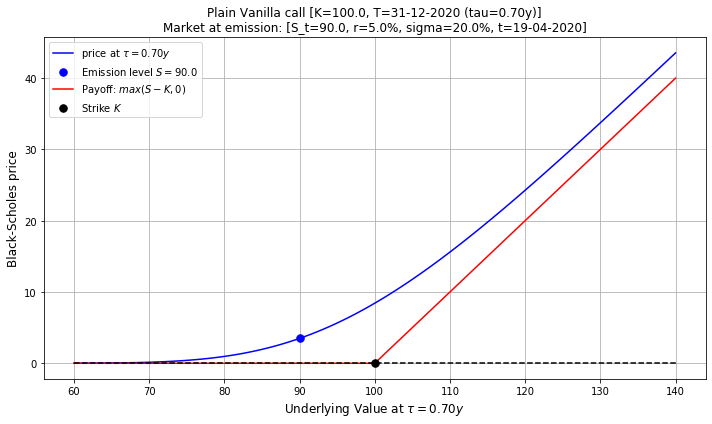

In [135]:
option_plotter.plot()

If you want price limits

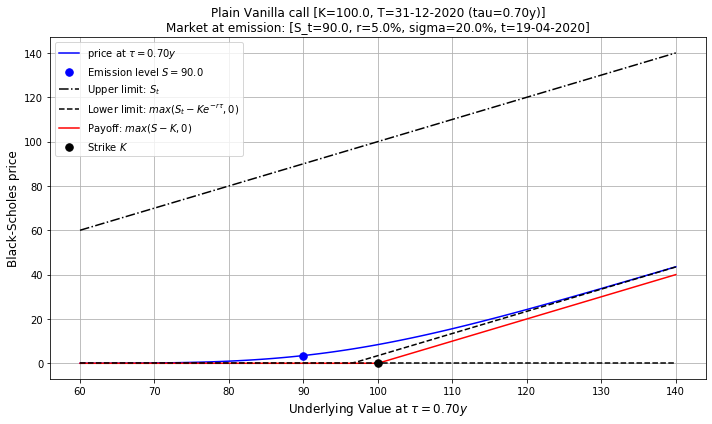

In [136]:
option_plotter.plot(plot_details=True)

Using a single 'dd-mm-YYYY' date String

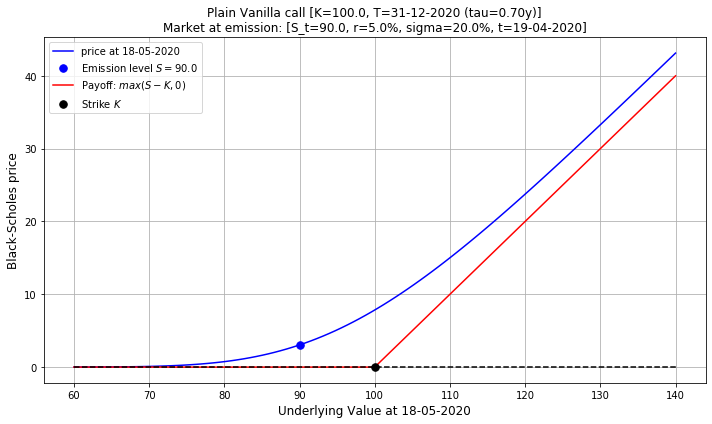

In [137]:
option_plotter.plot(t="18-05-2020")

or a `dt.datetime` object to specify the valuation date

In [138]:
datetime_date

datetime.datetime(2020, 6, 8, 0, 0)

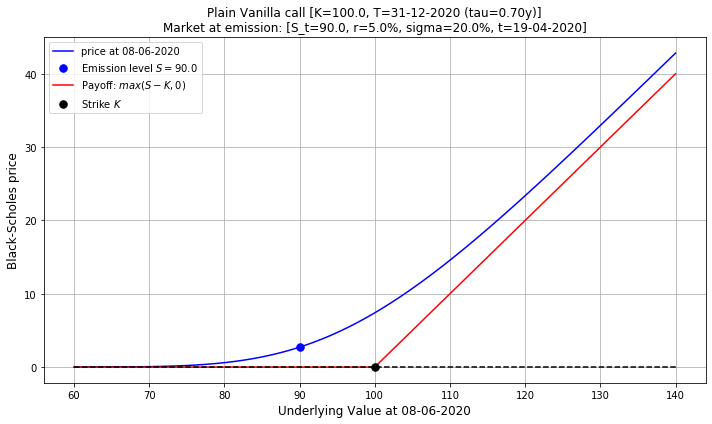

In [139]:
option_plotter.plot(t=datetime_date)

If you want to plot multiple times-to-maturity in a single plot

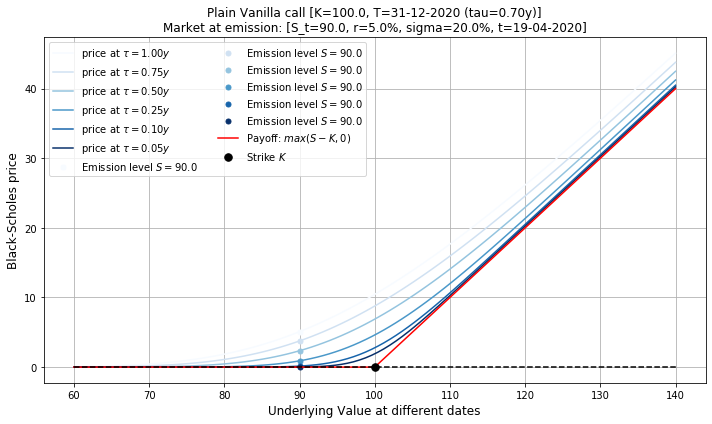

In [140]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

If instead you want to plot multiple dates

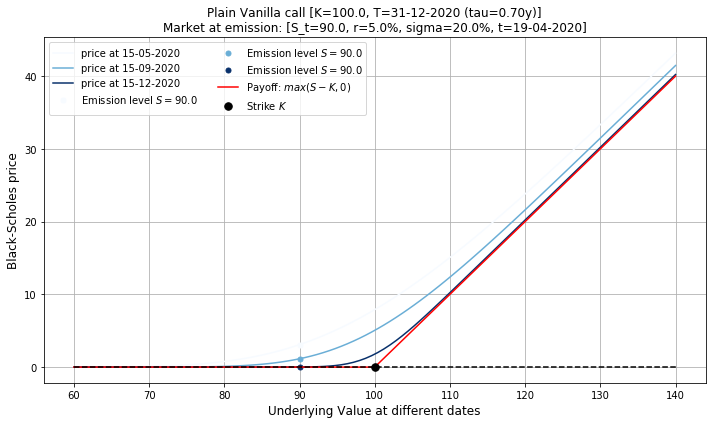

In [141]:
option_plotter.plot(t=['15-05-2020', '15-09-2020', '15-12-2020'])

Finally, you can also use a `pd.date_range` to define multiple valuation dates

In [142]:
emission_date = Vanilla_Call.get_t()
emission_date

datetime.datetime(2020, 4, 19, 0, 0)

In [143]:
expiration_date = Vanilla_Call.get_T()
expiration_date

datetime.datetime(2020, 12, 31, 0, 0)

In [144]:
almost_expiration_date = expiration_date - dt.timedelta(days=10)
almost_expiration_date

datetime.datetime(2020, 12, 21, 0, 0)

In [145]:
multiple_datetime_valuation_dates = pd.date_range(start=emission_date, end=almost_expiration_date, periods=5)
multiple_datetime_valuation_dates

DatetimeIndex(['2020-04-19 00:00:00', '2020-06-19 12:00:00',
               '2020-08-20 00:00:00', '2020-10-20 12:00:00',
               '2020-12-21 00:00:00'],
              dtype='datetime64[ns]', freq=None)

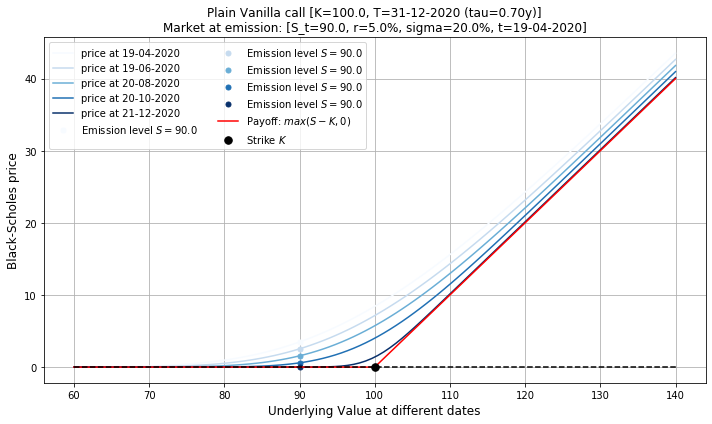

In [146]:
option_plotter.plot(t=multiple_datetime_valuation_dates)

Let's make an example with a cash-or-nothing puts for completeness

In [147]:
CON_Put

DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [148]:
option_plotter = OptionPlotter(CON_Put)

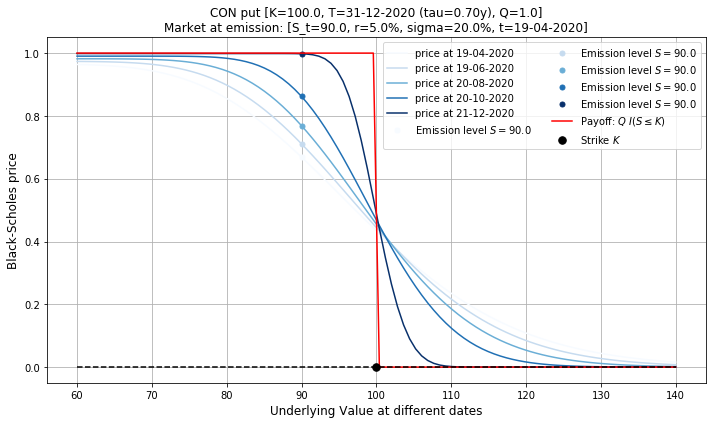

In [149]:
option_plotter.plot(t=multiple_datetime_valuation_dates)

## 2.4. Profit and Loss: `PnL` method  <a name="pnl"></a>

We now define the P&L generated owning an option contract. We consider an option contract expiring at time $T$, bought at time $t<T$ for an initial price $p_t$. At any time $t \leq s < T$, when the current underlying value is $S$ and the current price of the option is $p_s(S)$, we define the P&L $P\&L_s(S)$ generated by holding that contract up to time $s$ as

$$
P\&L_s(S) = p_s(S) - p_t \mbox{ if } t \leq s < T
$$

that is, the P&L is the positive/negative money balance generated in case the option is sold at time $s < T$ for the current price $p_s(S)$ when the underlying value is $S$. Notice that option's price moves because of: 

- the decrease in the residual life of the option - from $T-t$ to $T-s < T-t$ - that is, the so-called _time decay_ of option prices; 

- the underlying value changes - from $S_t$ at time $t$ to $S$ at time $s$. 

Other price dependencies ($r$, $T$, $K$ and $\sigma$) stay unchanged between time $t$ and $s$.

In the particular case in which $s \equiv T$ (that is $\tau \equiv 0$), that is the case in which the option is hold until maturity, the P&L is computed as the difference between the payoff it provides (positive if exercised, zero otherwise) and the initial price $p_t$

$$
P\&L_s(S) = \mbox{payoff}(S) - p_t \mbox{ if } s \equiv T
$$

where, in the case of a plain vanilla option: $\mbox{payoff}(S) = \max (S - K, 0)$ paid at time $T$.

Notice that comparing the current option's price $p_s(S)$ (at time $s$) with its initial price $p_t$ (at time $t$), intentionally neglects the time value of money. Indeed, we should discount the current price of the option to make it comparable with initial price, such that a formally correct P&L computation would be

$$
P\&L_s(S) = e^{-r(s-t)} p_s(S) - p_t 
$$

given the constant and deterministic short-rate $r$ we are using. Nevertheless, the undiscounted version is more commonly used and we conform to it.

Here we present our `EuropeanOption` class with the computation of P&L implemented

In [150]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    It uses a MarketEnvironment object to define the current market conditions under which the option is modeled. 
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  Optional. Type of the option. Can be either 'call' or 'put';
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   Optional. Strike price;
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        Optional. Expiration date. Can be either a "dd-mm-YYYY" String or a dt.datetime object
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.

    Public Methods:
    --------
    
        time_to_maturity: float
            Computes the time-to-maturity of the option.
        
        parse_S_tau_parameters: float
            Parses underlying and time parameters, discribinating between time-to-maturity and valuation date
            time parameter.
    
        d1_and_d2: flaot, float
            Computes the d1 and d2 terms of Black-Scholes pricing formula

        PnL: float
            Computes the P&L of the option.

    Template Methods:
    --------   
    
        getters for all common attributes
        
        setters for common attributes, not belonging to mkt_env
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """

    def __init__(self, mkt_env, option_type='call', K=100.0, T="31-12-2020"):
        
        print("Initializing the EuropeanOption!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = mkt_env.get_S()
        self.__K     = K
        self.__t     = mkt_env.get_t()
        self.__T     = date_string_to_datetime_obj(T)
        self.__tau   = self.time_to_maturity()
        self.__r     = mkt_env.get_r()
        self.__sigma = mkt_env.get_sigma()
        
        # empty initial price of the option
        self.__initial_price = None
               
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau

    def get_r(self):
        return self.__r
    
    def get_sigma(self):
        return self.__sigma
    
    def get_initial_price(self):
        return NotImplementedError()
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_K(self, K):
        self.__K = K
    
    def set_T(self, T):
        self.__T = date_string_to_datetime_obj(T)
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        self.__update_T()
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # utility methods
    def time_to_maturity(self, *args, **kwargs):
        """
        Utility method to compute time-to-maturity
        """
        
        # parsing optional parameters
        t = args[0] if len(args) > 0 else kwargs['t'] if 't' in kwargs else self.get_t()
        T = args[1] if len(args) > 1 else kwargs['T'] if 'T' in kwargs else self.get_T()
        
        # convert to dt.datetime objects, if needed
        t = date_string_to_datetime_obj(t)
        T = date_string_to_datetime_obj(T)
        
        # compute and return time to maturity (in years)
        return (T-t).days / 365.0
    
    def parse_S_tau_parameters(self, *args, **kwargs):
        """
        Utility method to parse underlying and time-parameters
        """

        # underlying value 
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()

        # time parameter:
        time_param = args[1] if len(args) > 1 \
                     else kwargs['tau'] if 'tau' in kwargs \
                        else (kwargs['t'] if 't' in kwargs else None)
        
        # check that no multiple time parameters in input
        if is_iterable_not_string(time_param):
            raise NotImplementedError("No multiple time parameters allowed: {} given in input.".format(time_param))

        # time parameter interpretation according to its type        
        # case 1: no time-parameter in input
        if time_param is None:
            tau = self.get_tau()
        # case 2: valid time-to-maturity in input
        elif is_numeric(time_param):
            tau = time_param
        # case 3: valuation date in input, to be converted into time-to-maturity
        elif is_date(time_param):
            valuation_date = date_string_to_datetime_obj(time_param)
            tau = self.time_to_maturity(t=valuation_date)
        # error case: the time parameter in input has a data-type that is not recognized
        else: 
            raise TypeError("Type {} of input time parameter not recognized".format(type(time_param)))

        return S, tau
    
    # d1 and d2 terms
    def d1_and_d2(self, *args, **kwargs):
        """
        Utility method to compute d1 and d2 terms of Black-Scholes pricing formula
        """
        
        # parsing optional parameters
        S     = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau   = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
        K     = args[2] if len(args) > 2 else kwargs['K'] if 'K' in kwargs else self.get_K()
        r     = args[3] if len(args) > 3 else kwargs['r'] if 'r' in kwargs else self.get_r()
        sigma = args[4] if len(args) > 4 else kwargs['sigma'] if 'sigma' in kwargs else self.get_sigma()
            
        # compute d1 and d2
        d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
        d2 = d1 - sigma * np.sqrt(tau)

        return d1, d2
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()
        
    # profit and loss calculation calculation - with optional *args and **kwargs parameters
    def PnL(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
        
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
        
        # if tau==0, this is the P&L at option's expiration, that is the PnL if the option is kept until maturity
        if tau == 0.0:
            # P&L = payoff - initial price
            return self.payoff(S) - self.get_initial_price()
        
        # if tau > 0, this is the P&L as if the option position is closed before maturity, when the time-to-maturity is tau
        else:
            # P&L = current price - initial price
            return self.price(S, tau) - self.get_initial_price()

Line 233: the `.PnL()` method implements the P&L. Notice that we decided to implement the `.PnL()` method as a public method in the base class because:
- its definition as difference between current and initial price is independent from the specific way in which price is computed;
- it is inherited, as public method, by all sub-classes;
- it delegetes to the ovverriden (polymorphic) `.price()` and `.payoff()` methods the sub-class-specific computation of the price/payoff.

Here our `PlainVanillaOption` and `DigitalOption` sub-classes

In [151]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Inherits from EuropeanOption base-class. Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   

        public methods inherited from EuropeanOption class

        payoff: float
            Overridden method. Computes the payoff of the option and returns it

        price_upper_limit: float 
            Overridden method. Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Overridden method. Returns the lower limit for a vanilla option price.
            
        price: float
            Overridden method. Computes the exact price of the option and returns it
            
    Usage: 
    --------   
        - default: PlainVanillaOption(mkt_env) is equivalent to 
                   PlainVanillaOption(mkt_env, option_type='call', K=100.0, T="31-12-2020")

        - general: PlainVanillaOption(mkt_env, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """
    
    # initializer with optional *args and **kwargs parameters
    def __init__(self, *args, **kwargs):  
        
        # calling the EuropeanOption initializer
        super(PlainVanillaOption, self).__init__(*args, **kwargs)
        
        # info strings
        self.__info = r"Plain Vanilla {} [K={:.1f}, T={} (tau={:.2f}y)]".format(self.get_type(), self.get_K(), datetime_obj_to_date_string(self.get_T()), self.get_tau())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%, t={}]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100, datetime_obj_to_date_string(self.get_t()))
        
        # initial price of the option
        self.__initial_price = self.price()
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_initial_price(self):
        return self.__initial_price

    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called using (underlying), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
        """
        
        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
                
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)
    
    def __call_payoff(self, S):
        if is_iterable(S):
            return np.array([max(0.0, s - self.get_K()) for s in S])
        else:
            return max(0.0, S - self.get_K())

    def __put_payoff(self, S):
        if is_iterable(S):
            return np.array([max(0.0, self.get_K() - s) for s in S])
        else:
            return max(0.0, self.get_K() - S)
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
                        
        # call case
        if self.get_type() == 'call':
            return S
        # put case
        else:
            return self.__put_price_upper_limit(S, tau)
    
    def __put_price_upper_limit(self, S, tau):
        if is_iterable(S):
            return np.repeat(self.get_K()*np.exp(-self.get_r() * tau), repeats=len(S)) 
        else:
            return self.get_K()*np.exp(-self.get_r() * tau)

    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
                                       
        # call case
        if self.get_type() == 'call':
            return self.__call_price_lower_limit(S, tau)
        # put case
        else:
            return self.__put_price_lower_limit(S, tau)

    def __call_price_lower_limit(self, S, tau):
        if is_iterable(S):
            return np.array([max(s - self.get_K()*np.exp(-self.get_r() * tau), 0.0) for s in S])
        else:
            return max(S - self.get_K()*np.exp(-self.get_r() * tau), 0.0)
                                       
    def __put_price_lower_limit(self, S, tau):
        if is_iterable(S):
            return np.array([max(self.get_K()*np.exp(-self.get_r() * tau) - s, 0.0) for s in S])
        else:
            return max(self.get_K()*np.exp(-self.get_r() * tau) - S, 0.0)
                                       
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
                       
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
               
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if is_iterable(S) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if is_iterable(S) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            K     = self.get_K()
            r     = self.get_r()
            
            # get d1 and d2 terms
            d1, d2 = self.d1_and_d2(S, tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price(S, tau) + self.get_K() * np.exp(- self.get_r() * tau) - S     

In [152]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Inherits from EuropeanOption base-class. Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        Q (float):                   cash amount
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
 
        public methods inherited from EuropeanOption class

        payoff: float
            Overridden method. Computes the payoff of the option and returns it

        price_upper_limit: float 
            Overridden method. Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Overridden method. Returns the lower limit for a vanilla option price.
            
        price: float
            Overridden method. Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: DigitalOption(mkt_env) is equivalent to 
                   DigitalOption(mkt_env, cash_amount=1.0, option_type='call', K=100.0, T="31-12-2020")

        - general: DigitalOption(mkt_env, cash_amount=Float, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """

    # initializer with optional *args and **kwargs parameters and default cash_amount
    # default keyword arguments (like cash_amount here) must go after args list argument in function def
    def __init__(self, *args, cash_amount=1.0, **kwargs):  
        
        # calling the EuropeanOption initializer
        super(DigitalOption, self).__init__(*args, **kwargs)
        
        # amount of cash in case of payment
        self.__Q = cash_amount    
        
        # info strings
        self.__info = r"CON {} [K={:.1f}, T={} (tau={:.2f}y), Q={:.1f}]".format(self.get_type(), self.get_K(), datetime_obj_to_date_string(self.get_T()), self.get_tau(), self.get_Q())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%, t={}]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100, datetime_obj_to_date_string(self.get_t()))
        
        # initial price of the option
        self.__initial_price = self.price()

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_Q(self):
        return self.__Q
    
    def get_initial_price(self):
        return self.__initial_price
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called using (underlying), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
        """
        
        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
        
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)

    def __call_payoff(self, S):
        if is_iterable(S):
            return np.array([self.get_Q() * int(s > self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S > self.get_K())

    def __put_payoff(self, S):
        if is_iterable(S):
            return np.array([self.get_Q() * int(s <= self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S <= self.get_K())
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
            
        # the same for call and put
        return self.__price_upper_limit(S, tau)
 
    def __price_upper_limit(self, S, tau):
        if is_iterable(S):
            return np.repeat(self.get_Q()*np.exp(-self.get_r() * tau), repeats=len(S))
        else:
            return self.get_Q()*np.exp(-self.get_r() * tau)
                                       
    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """

        # underlying value
        S, _ = self.parse_S_tau_parameters(*args, **kwargs)
            
        # call case
        if self.get_type() == 'call':
            return np.repeat(0.0, repeats=len(S)) if is_iterable(S) else 0.0
        # put case
        else:
            return np.repeat(0.0, repeats=len(S)) if is_iterable(S) else 0.0
        
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: .get_S() is used,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A valuation date (e.g. t='15-05-2020'): either a 'dd-mm-YYYY' String or a dt.datetime object
            - A time-to-maturity value (e.g. tau=0.5)
        """
                       
        # underlying value and time-to-maturity
        S, tau = self.parse_S_tau_parameters(*args, **kwargs)
            
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if is_iterable(S) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if is_iterable(S) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
                
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            Q = self.get_Q()
            r = self.get_r()
            
            # get d2 term
            _, d2 = self.d1_and_d2(S, tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * tau) - self.__call_price(S, tau)        

Notice the use, in both sub-classes, of `self.__initial_price` (private) attribute in the initializer and `.get_initial_price()` getter that implement the initial price computation once and whenever the class is instantiated.

Here are a couple of examples of P&L computation

In [153]:
Vanilla_Call = PlainVanillaOption(market_env)
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

the initial price of the option $p_t$

In [154]:
Vanilla_Call.get_initial_price() # initial price: time t=19-04-2020 and S_t = 90.0

3.487402470943657

the price $p_s(S=\$110)$ on $s=$ June 1st, 2020

In [155]:
Vanilla_Call.price(S=110, t="01-06-2020") # current price: time s=01-06-2020 and S_s = 110.0

14.72170943745732

the $P\&L_s (S=\$110)$ on $s=$ June 1st, 2020

In [156]:
Vanilla_Call.PnL(S=110, t="01-06-2020") # PnL: time s=01-06-2020 and S_s = 110.0

11.234306966513664

we can verify the P&L computation, comparing it with the difference $p_s(S=\$110) - p_t$

In [157]:
Vanilla_Call.price(S=110, t="01-06-2020") - Vanilla_Call.get_initial_price() # PnL verification

11.234306966513664

the two coincide. We can also consider the P&L at expiration date $s \equiv T=$ December 31st, 2020

In [158]:
expiration_date = Vanilla_Call.get_T()
expiration_date

datetime.datetime(2020, 12, 31, 0, 0)

In [159]:
Vanilla_Call.PnL(S=110, t=expiration_date) # PnL at expiration: time s=T=31-12-2020 and S_s = 110.0

6.512597529056343

and verify it comparing with the payoff paid at $T$: $\mbox{payoff}(S=\$110) = \max (S - K, 0) = \max (\$ 110 - \$ 100, 0) = \$ 10$

In [160]:
Vanilla_Call.payoff(S=110) # payoff at S=110

10.0

In [161]:
Vanilla_Call.payoff(S=110) - Vanilla_Call.get_initial_price() # PnL at maturity verification

6.512597529056343

the two coincide.

### 2.4.1. _Time decay_ of option prices  <a name="aging"></a>

Let's quickly consider the _time decay_ effect alone, that is the decrease in the residual life of the option from $T-t$ on date $t=$ April 19th, 2020 to $T-s < T-t$ as the option approaches its expiration date. We perform this analysis holding fixed the underlying value (as well as all other pricing parameters) at its emission value $S \equiv S_t = \$ 90$

In [162]:
p_t = Vanilla_Call.get_initial_price() # initial price
p_t

3.487402470943657

In [163]:
S_t = Vanilla_Call.get_S() # underlying level at emission
S_t

90.0

In [164]:
Vanilla_Call.price(S=S_t, t="01-06-2020") # price at a future date

2.8272047131286087

that is its price decreases. In other words, if the market stays unchanged at the underlying emission level $S_t$ at which we bought the option, the P&L generated by selling the option at any future date is negative. 

In [165]:
Vanilla_Call.PnL(S=S_t, t="01-06-2020") # P&L at a future date

-0.6601977578150482

This effect is easily understood thinking that owning an option of longer residual life means having more opportunities with respect to owning one with a shorter residual life. Therefore, considering that the option's expiration date (December 31st, 2020) is fixed by contract, the trader buying from us that option on June 1st, 2020 is willing to pay us less than what we paid to buy that option on April 19th, 2020 (all else being equal, especially $S \equiv S_t$).

### 2.4.2. Extending `Plotter` class to plot P&L: `getattr` <a name="getattr"></a>

Now that we can compute the P&L of our options, we want to be able to plot it. Instead of writing a dedicated plotting function just to plot the P&L, we want to recycle as much code as possible.

In particular, we want to make our `.plot()` method (line 97) of the `OptionPlotter` class more general. We want it to be able to plot a generic method, such as `.price()` or `.PnL()`, against the underlying value $S$. But how can we make `.plot()` using a generic method of our options' classes without hard-coding its name in `.plot()`'s definition? 

Luckily this is possible. The built-in [function `getattr`](https://python-textbok.readthedocs.io/en/1.0/Classes.html?highlight=getattr#getattr-setattr-and-hasattr) with syntax

```python
getattr(anObject, 'methodName')
```

returns (a pointer to) the `anObject`'s method specified by the String identifier `'methodName'`. Then we can call that method using the `()` input operator as we would do with any other function/method

```python
output_values = getattr(anObject, 'methodName')(input_parameters)
```

which is equivalent to

````python
output_values = anObject.methodName(input_parameters)
```

If `.methodName()` is not a method of `anObject`, `getattr` will raise an error.

For example, computing the price as

In [166]:
getattr(Vanilla_Call, 'price')(S=110, t="01-06-2020")

14.72170943745732

is equivalent to computing it as 

In [167]:
Vanilla_Call.price(S=110, t="01-06-2020") # current price: time s=01-06-2020 and S_s = 110.0

14.72170943745732

In this version of `OptionPlotter` we distinguish between a price Vs $S$ plot and a P&L Vs $S$ plot according to the value of the `plot_metrics` String, which is an optional keyboard parameter of `.plot()` (either `'price'`, default,  or `'PnL'` accepted) which is parsed by `.parse_plot_metrics()` utility function (line 83)

In [168]:
class OptionPlotter:
    """
    Plotter class to plot the price/P&L of options. It implements a composition with an underlying `FinancialInstrument` 
    object to access option-specific attributes.
    
    Attributes:
    -----------
        FinancialInstrument (PlainVanillaOption or DigitalOption):    Instance of an EuropeanOption sub-class
        x_axis (np.ndarray):                                          An array representing the x-axis of the plot.
        time_parameter (single or Iterable date or time-to-maturity): A single value or Iterable object representing the
                                                                      time(s)-to-maturity or valuation date(s) at which the
                                                                      plot has to be made.
        title_label (String):                                         String representing the plot title. From .get_info()
                                                                      and .get_mkt_info() of FinancialInstrument.
    
    Public Methods:
    --------   
    
        getters for all attributes
        
        x_axis and time_parameter utility functions
        
        time_parameter utility method to discriminate between single or Iterable time_parameter.
        
        parse_plot_metrics utility method to parse 'plot_metrics' optional parameter of .plot() method.
            Plot metrics are either 'price' or 'PnL'
        
        parse_plot_details utility method to parse 'plot_details' optional parameter of .plot() method.
            If True, upper and lower price boundaries are shown if .__plot_single_time() method is called. 
        
        plot:
            Public method to plot the price/P&L of the FinancialInstrument. 
            It uses .__plot_single_time() or .__plot_multi_time() (private) methods depending on whether time_parameter 
            is a single value or an Iterable.

    """
    
    def __init__(self, FinancialInstrument):

        # parse informations from FinancialInstrument
        self.fin_inst = FinancialInstrument
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market at emission: " + self.fin_inst.get_mkt_info()

        # set default x-axis 
        self.__x_axis = self.x_axis(self.fin_inst.get_K())

        # set default time parameter
        self.__time_parameter, _ = self.time_parameter(self.fin_inst.get_tau())
        
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_time_parameter(self):
        return self.__time_parameter

    def get_title(self):
        return self.__title_label
    
    # utility methods
    def x_axis(self, *args, **kwargs):
        """
        Utility method to define the x-axis of the plot, optionally parsing x-axis in input.
        """
        
        # parsing optional parameter
        x = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_x_axis()
        
        # define the x-axis
        
        # case 1: a list of x-points in input. The x-axis is a wide range, including x-points
        if is_iterable(x):
            x_min = max(min(x)-20, 0.0)
            x_max = max(x)+20
        # case 2: a single x-point in input. The x-point is the middle point of the x-axis
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20

        return np.linspace(x_min, x_max, 100)
    
    def time_parameter(self, *args, **kwargs):
        """
        Utility method to define the time parameter of the plot, optionally parsing time parameter in input.
        It returns appropriate time parameter labels too.
        """
        
        # parsing optional parameter: notice the backslash operator '\' 
        # to split code into multiple lines for readability
        time = args[0] if len(args) == 1 \
               else args[1] if len(args) > 1 \
                   else (kwargs['tau'] if 'tau' in kwargs \
                       else (kwargs['t'] if 't' in kwargs else self.get_time_parameter()))
        
        # case 1: time-to-maturity in input (if Iterable, sort from longest to shortest)
        if is_numeric(time):
            time_parameter = np.sort(time)[::-1] if is_iterable_not_string(time) else time
            time_parameter_label = np.array([r"$\tau={:.2f}y$".format(tau) for tau in time_parameter]) \
                                    if is_iterable_not_string(time) else r"$\tau={:.2f}y$".format(time_parameter)

        # case 2: valuation date in input (if Iterable, sort from first to last, i.e. chronological order)
        elif is_date(time):
            time_parameter = np.array(sorted(time, key=date_string_to_datetime_obj)) if is_iterable_not_string(time) else time
            time_parameter_label = np.array([datetime_obj_to_date_string(t) for t in time_parameter]) \
                                    if is_iterable_not_string(time) else datetime_obj_to_date_string(time_parameter)

        else:
            raise TypeError("Time parameter {} in input has not recognized data-type \
                             (only 'dd-mm-YYYY' Strings or dt.datetime objects allowed)".format(type(time_parameter)))
            
        # case of one-element Iterable: reduced to scalar variables
        if is_iterable(time_parameter) and len(time_parameter) == 1:
            time_parameter = time_parameter[0]
            time_parameter_label = time_parameter_label[0]
                
        return time_parameter, time_parameter_label
    
    def parse_plot_metrics(self, **kwargs):
        """
        Utility method to parse the metrics of the plot: either 'price' or 'PnL'.
        """
        plot_metrics = kwargs['plot_metrics'] if 'plot_metrics' in kwargs else 'price'
        return plot_metrics
    
    def parse_plot_details(self, **kwargs):
        """
        Utility method to decide whether to plot details or not.
        """
        plot_details = kwargs['plot_details'] if 'plot_details' in kwargs else False
        return plot_details
                    
    def plot(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter, plot-metrics, plot-details), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: option's strike price is used as middle point of the x-axis,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 1st positional argument (if no underlying is specified) or
          as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A single (e.g. t='15-05-2020') / Iterable (e.g. pd.date_range) valuation date(s): 
              accepted types are either a 'dd-mm-YYYY' String or a dt.datetime object
            - A single (e.g. tau=0.5) / Iterable time-to-maturity value(s) 
            
        - plot-metrics can be specified as keyboard argument 'plot_metrics'. It's value can be:
        
            - Empty: default value used is 'price'
            - plot_metrics = a String 'method' corresponding to a valid '.method()' implemented by self.fin_inst object  
            
        - plot-details can be specified as keyboard argument 'plot_details'. If True, upper and lower price boundaries 
          are shown if .__plot_single_time() method is called. It's value can be:
        
            - Empty: default value used is False
            - plot_details = True or False
        """
        
        # argument parsing and plot setup
        x_axis = self.x_axis(*args, **kwargs)
        time_parameter, time_label_parameter = self.time_parameter(*args, **kwargs)
        plot_metrics = self.parse_plot_metrics(**kwargs)

        if is_iterable_not_string(time_parameter):
            self.__plot_multi_time(x_axis, time_parameter, time_label_parameter, plot_metrics)
        else:
            plot_limits = self.parse_plot_details(**kwargs)
            self.__plot_single_time(x_axis, time_parameter, time_label_parameter, plot_metrics, plot_limits)
                    
    def __plot_multi_time(self, S, multiple_times, time_labels, plot_metrics):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple dates.
        Dates can be specified either as date Strings or time-to-maturity values.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multiple_times))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different date
        for time, time_label in zip(multiple_times, time_labels):
            ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), '-', lw=1.5, 
                    label=plot_metrics + r" at " + time_label)

        # blue dot at original underlying level for reference
        for time, time_label in zip(multiple_times, time_labels):
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), '.', ms=10, 
                    label=r"Emission level $S={:.1f}$".format(S_t))
            
        # plot the red payoff line for different underlying values
        if plot_metrics == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different dates", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
 
    def __plot_single_time(self, S, time, time_label, plot_metrics, plot_limits):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed date. 
        Date can be specified either as date String or time-to-maturity value.
        Optionally, it plots theoretical upper and lower bounds of the price.
        """
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), 'b-', lw=1.5, 
                label=plot_metrics + r" at " + time_label)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), 'b.', ms=15, 
                label=r"Emission level $S={:.1f}$".format(S_t))
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, time), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, time), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        if plot_metrics == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at " + time_label, fontsize=12) 
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

Here are some plotting examples

In [169]:
market_env

MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

In [170]:
Vanilla_Call

PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [171]:
option_plotter = OptionPlotter(Vanilla_Call)

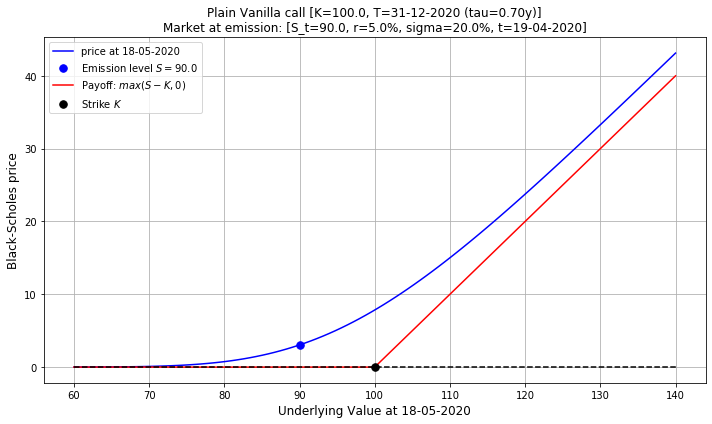

In [172]:
option_plotter.plot(t="18-05-2020") # option price on May 18th, 2020

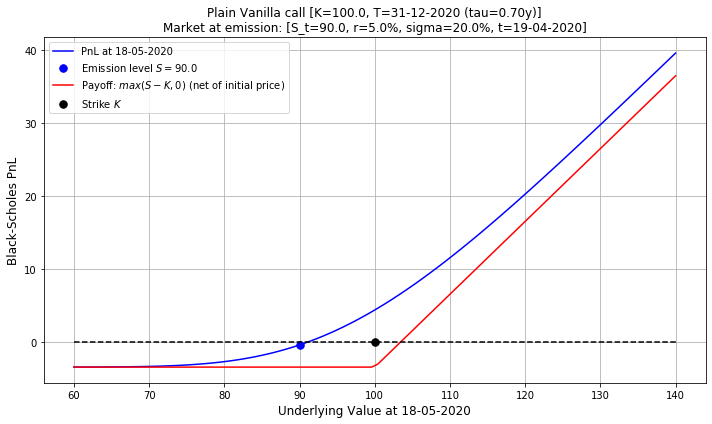

In [173]:
option_plotter.plot(t="18-05-2020", plot_metrics='PnL') # option P&L on May 18th, 2020

In [174]:
multiple_datetime_valuation_dates

DatetimeIndex(['2020-04-19 00:00:00', '2020-06-19 12:00:00',
               '2020-08-20 00:00:00', '2020-10-20 12:00:00',
               '2020-12-21 00:00:00'],
              dtype='datetime64[ns]', freq=None)

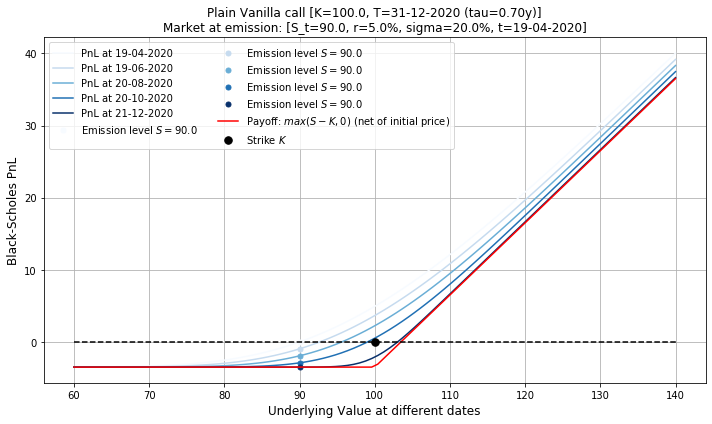

In [175]:
option_plotter.plot(t=multiple_datetime_valuation_dates, plot_metrics='PnL') # P&L at multiple dates

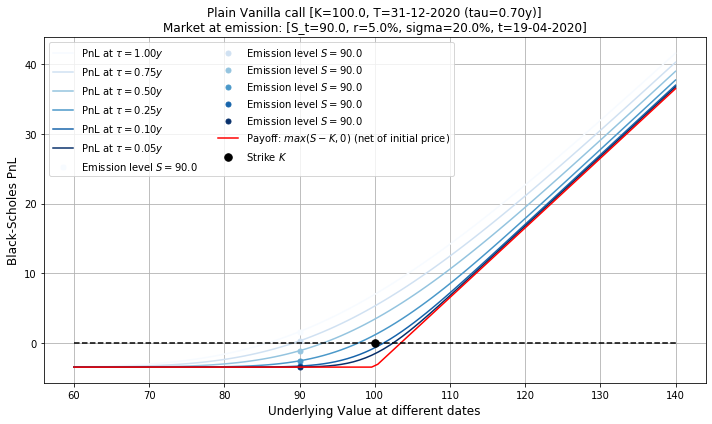

In [176]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0], plot_metrics='PnL') # P&L at multiple time(s)-to-maturity

Let's make an example using a digital option

In [177]:
CON_Put = DigitalOption(market_env, option_type='put')
CON_Put

Initializing the EuropeanOption!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [178]:
option_plotter = OptionPlotter(CON_Put)

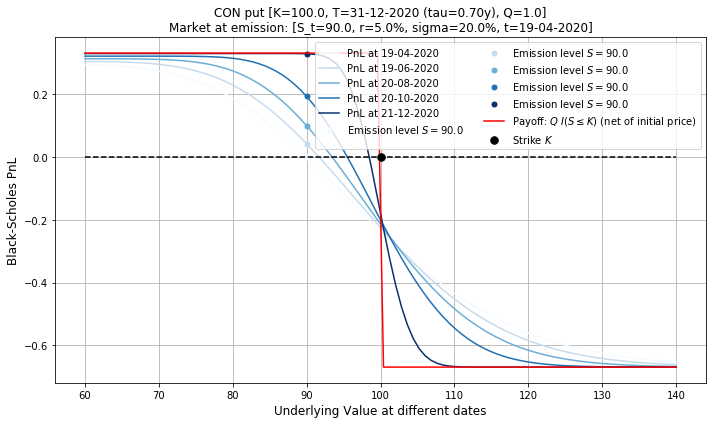

In [179]:
option_plotter.plot(t=multiple_datetime_valuation_dates, plot_metrics='PnL') # P&L at multiple dates

# 3. A portfolio of options: `Portfolio` class <a name="portfolio"></a>

As additional application of the _composition_ relationship, we consider a portfolio of options. We model it as a many-Options-to-1-Portfolio composition. 

Here is the `Portfolio` class

In [180]:
class Portfolio:
    """
    Portfolio class modeling a portfolio of options. It implements an aggregation of EuropeanOption sub-classes 
    defining the .add_instrument() composition method which takes in input a FinancialInstrument (either PlainVanillaOption or 
    DigitalOption) to be added to the portfolio.
    
    Attributes:
    -----------
    
        composition (List of Dicts): List of Dicts, each describing a single constituent FinancialInstrument, together
                                     with the position the portfolio is holding on it.
        info and mkt_info (Strings): information labels on portfolio and constituent instruments.
        S (Float):                   underlying value when the portfolio is formed.
        K (np.ndarray):              Strikes of constituent options.
        tau (np.ndarray):            Time(s) to maturity of constituent options, when the portfolio is formed.
        is_multi_horizon (Bool):     True if constituent options have different expiration dates.
        
    Public Methods:
    --------
    
        getters for all attributes
        
        setters for common attributes, not belonging to mkt_env
        
        payoff: float
            Computes the payoff of the portfolio.

        price: float
            Computes the value of the portfolio.

        PnL: float
            Computes the P&L of the portfolio.
    """
    
    def __init__(self, name="Dummy"):
        
        # initialize an empty portfolio
        self.__composition = []
        
        # initialize empty info strings
        self.__info = "{} Portfolio: \n".format(name)
        self.__mkt_info = None
        
        # initialize underlying value, strikes and times-to-maturity attributes
        self.__S = None
        self.__K = np.array([])
        self.__tau = np.array([])
        self.is_multi_horizon = False
        
    def __repr__(self):
        return self.get_info()
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_K(self):
        return self.__K
    
    def get_S(self):
        return self.__S

    def get_tau(self):
        return self.__tau
    
    def get_composition(self):
        return self.__composition
    
    # setters
    def set_S(self, S):
        self.__S = S
        
    # composition method
    def add_instrument(self, FinancialInstrument, position):
        
        long_short = 'Long' if position > 0 else 'Short'
        instrument_info = long_short + " {} ".format(abs(position)) + FinancialInstrument.get_info()
        
        self.__composition.append({"instrument": FinancialInstrument,
                                   "position":   position,
                                   "info":       instrument_info})
        
        # update portfolio info strings
        self.__update_info(FinancialInstrument, position)
        
        # update portfolio attributes
        self.__update_S(FinancialInstrument)
        self.__update_K(FinancialInstrument)
        self.__update_tau(FinancialInstrument)
    
    # private method to update the info
    def __update_info(self, fin_inst, pos):
        self.__info += self.__composition[-1]["info"] + "\n"
        if self.__mkt_info is None:
            self.__mkt_info = fin_inst.get_mkt_info()
            
    def __update_S(self, fin_inst):
        if self.get_S() is None:
            self.set_S(fin_inst.get_S())

            
    def __update_K(self, fin_inst):
        # append new instrument strike
        strikes = np.append(self.get_K(), fin_inst.get_K())
        # filter only distinct strikes
        self.__K = np.unique(strikes)

    def __update_tau(self, fin_inst):
        # append new instrument tau
        times_to_maturity = np.append(self.get_tau(), fin_inst.get_tau())
        # filter only distinct times-to-maturity
        self.__tau = np.unique(times_to_maturity)
        # check if the portfolio is a multi-horizon portfolio
        if len(self.__tau) > 1:
            self.is_multi_horizon = True
                    
    def __check_time_parameter(self, *args, **kwargs):
        
        # time parameter:
        time_param = args[1] if len(args) > 1 \
                        else kwargs['tau'] if 'tau' in kwargs \
                            else (kwargs['t'] if 't' in kwargs else None)
        
        # check that no multiple time parameters in input
        if is_iterable_not_string(time_param):
            raise NotImplementedError("No multiple time parameters allowed: {} given in input.".format(time_param))
            
        # check that time parameter is not a time-to-maturity if the portfolio is multi-horizon:
        if self.is_multi_horizon and is_numeric(time_param):
            raise NotImplementedError("No time-to-maturity time parameter allowed for multi-horizon \n{} \ntau={} given in input"\
                                      .format(self, time_param))  
            
    # portfolio "payoff", that is expiration value
    def payoff(self, *args, **kwargs):
        """
        Returns the portfolio payoff as the scalar product (i.e. sum of elementwise products) 
        between single instrument payoffs and positions.
        
        As single instruments .payoff(), can be called with single/multiple 'S' and single 't' or 'tau'. 
        """
           
        # check time parameter
        self.__check_time_parameter(*args, **kwargs)
              
        if self.get_composition(): 

            # single instrument payoffs and positions
            payoffs = np.array([inst["instrument"].payoff(*args, **kwargs) for inst in self.get_composition()])
            positions = np.array([inst["position"] for inst in self.get_composition()])
            
            return positions.dot(payoffs)
            
        else: # if portfolio is empty returns 0
            
            return 0.0  
        
    # portfolio value (called 'price' as for single options, to implement polymorphism)
    def price(self, *args, **kwargs):
        """
        Returns the portfolio value as the scalar product (i.e. sum of elementwise products) 
        between single instrument prices and positions.
        
        As single instruments .price(), can be called with single/multiple 'S' and single 't' or 'tau'. 
        """
        
        # check time parameter
        self.__check_time_parameter(*args, **kwargs)
                                      
        if self.get_composition(): 

            # single instrument prices and positions
            prices = np.array([inst["instrument"].price(*args, **kwargs) for inst in self.get_composition()])
            positions = np.array([inst["position"] for inst in self.get_composition()])
            
            return positions.dot(prices)
            
        else: # if portfolio is empty returns 0
            
            return 0.0  
        
    # portfolio P&L
    def PnL(self, *args, **kwargs):
        """
        Returns the portfolio Profit & Loss as the scalar product (i.e. sum of elementwise products) 
        between single instrument P&Ls and positions.
        
        As single instruments .PnL(), can be called with single/multiple 'S' and single 't' or 'tau'. 
        """
                
        # check time parameter
        self.__check_time_parameter(*args, **kwargs)
                                      
        if self.get_composition(): 

            # single instrument P&Ls and positions
            pnls = np.array([inst["instrument"].PnL(*args, **kwargs) for inst in self.get_composition()])
            positions = np.array([inst["position"] for inst in self.get_composition()])
            
            return positions.dot(pnls)
            
        else: # if portfolio is empty returns 0
            
            return 0.0  

Line 45: the `.add_instrument()` method is used to add new options to the (originally empty) portfolio. The portfolio is essentially described by its `__composition` attribute, which is a Dict storing the positive/negative `position` amount held in the option and the particular `FinancialInstrument` option object itself.


Line 88: the (private) method `.__check_time_parameter()` is used to do some consistency checks on the time-parameter in input to the public portfolio methods. Notice, in particular, the use of `self.is_multi_horizon` (signaling a portfolio of options not expiring on the same date $T$) to disable the input of a time-to-maturity $\tau$ time parameter in the case of a multi-horizon portfolio. We have made this choice for ease of exposition, since the _time-to-maturity_ of a multi-horizon portfolio would be a rather subjective concept. We'll see an example of multi-horizon portfolio talking about the  _calendar-spread,_ an option strategy involving two options of same strike by different expiration dates.


Lines 105, 129, 153: public methods of `Portfolio` class, `.payoff()`, `.price()` and `.PnL()` implement the _agnostic_ flow of the arguments to the isntrument's specific corresponding method thanks to the use of `*args` `**kwargs` optional arguments. 

Notice also the use of Numpy array's `.dot()` method which implements the scalar product $\cdot$ (sum of element-wise products of two arrays) to compute the portfolio metrics, given the two arrays of positions and instrument specific metric.

For example: given $x=[1, 2, 3]$ and $y=[-1, 0, 1]$, their scalar product is the number $x \cdot y = 1 \times (-1) + 2 \times 0 + 3 \times 1 = 2$.

In [181]:
x = np.array([1, 2, 3])
y = np.array([-1, 0, 1])

x.dot(y)

2

Let's now build a _dummy_ portfolio and in the next sections we implement real-world option strategies using the `Portfolio` class. Let's begin with an empty portfolio

In [182]:
dummy_ptf = Portfolio()
dummy_ptf

Dummy Portfolio: 

add a _long_ position on 1 plain-vanilla call option of strike $K=\$110$

In [183]:
Vanilla_Call = PlainVanillaOption(market_env, K=110)
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [184]:
dummy_ptf.add_instrument(Vanilla_Call, 1)

In [185]:
dummy_ptf

Dummy Portfolio: 
Long 1 Plain Vanilla call [K=110.0, T=31-12-2020 (tau=0.70y)]

Let's compute (and verify) portfolio price

In [186]:
dummy_ptf.price(S=110, t='01-06-2020')

8.303219888493018

In [187]:
1 * Vanilla_Call.price(S=110, t='01-06-2020')

8.303219888493018

and P&L

In [188]:
dummy_ptf.PnL(S=110, t='01-06-2020')

6.912314048483937

In [189]:
1 * Vanilla_Call.PnL(S=110, t='01-06-2020')

6.912314048483937

Let's now add a _short_ position on 5 plain-vanilla put option contracts of strike $K=\$80$. That is, the owner of this portfolio is buying 1 call options and selling 5 put options

In [190]:
Vanilla_Put = PlainVanillaOption(market_env, option_type='put', K=80)
Vanilla_Put

Initializing the EuropeanOption!


PlainVanillaOption('put', S_t=90.0, K=80.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [191]:
dummy_ptf.add_instrument(Vanilla_Put, -5)

In [192]:
dummy_ptf

Dummy Portfolio: 
Long 1 Plain Vanilla call [K=110.0, T=31-12-2020 (tau=0.70y)]
Short 5 Plain Vanilla put [K=80.0, T=31-12-2020 (tau=0.70y)]

Let's compute (and verify) portfolio price

In [193]:
dummy_ptf.price(S=110, t='01-06-2020')

8.02598744151932

In [194]:
1 * Vanilla_Call.price(S=110, t='01-06-2020') + (-5) * Vanilla_Put.price(S=110, t='01-06-2020')

8.02598744151932

and P&L

In [195]:
dummy_ptf.PnL(S=110, t='01-06-2020')

13.47303139734534

In [196]:
1 * Vanilla_Call.PnL(S=110, t='01-06-2020') + (-5) * Vanilla_Put.PnL(S=110, t='01-06-2020')

13.47303139734534

## 3.1. `PortfolioPlotter` from a `Plotter` base class <a name="plotter"></a>

To visualize the metrics of our Portfolio, we need plotting functionalities. In the spirit of recycling as much code as possible and organize related code in logically coherent units, we define plotting functionalities for our `Portfolio` class in a `PortfolioPlotter` which we model, together with `OptionPlotter` class for single options, as sub-class of a generic `Plotter` class. We are thus using inheritance.

In [197]:
class Plotter:
    """
    Interface Plotter class to plot the price/P&L of options or portfolio of options. It implements a composition with 
    an underlying `FinancialObject` object to access option-/portfolio-specific attributes. This class is not meant to be 
    instantiated. 
    
    Attributes:
    -----------
        FinancialObject (EuropeanOption sub-class or Portfolio):      Instance of an EuropeanOption sub-class 
                                                                      (PlainVanillaOption or DigitalOption) or a Portfolio 
                                                                      class.
        x_axis (np.ndarray):                                          An array representing the x-axis of the plot.
        time_parameter (single or Iterable date or time-to-maturity): A single value or Iterable object representing the
                                                                      time(s)-to-maturity or valuation date(s) at which the
                                                                      plot has to be made.
        title_label (String):                                         String representing the plot title. From .get_info()
                                                                      and .get_mkt_info() of FinancialInstrument.
    
    Public Methods:
    --------   
    
        getters for all attributes
        
        x_axis utility method to set x-axis
        
        time_parameter utility method to discriminate between single or Iterable time_parameter.
        
        parse_plot_metrics utility method to parse 'plot_metrics' optional parameter of .plot() method.
        
        parse_plot_details utility method to parse 'plot_details' optional parameter of .plot() method.
        
    Template Methods:
    --------   
    
        plot:
            Template method to plot the price/P&L of the FinancialObject. It raises a NotImplementedError if called.

    """
    
    def __init__(self, FinancialObject):
        
        print("Calling the Plotter initializer!")
        
        # parse informations from FinancialInstrument
        self.fin_inst = FinancialObject
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market at emission: " + self.fin_inst.get_mkt_info()

        # set default x-axis 
        self.__x_axis = self.x_axis(self.fin_inst.get_K())

        # set default time parameter
        self.__time_parameter, _ = self.time_parameter(self.fin_inst.get_tau())
               
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_time_parameter(self):
        return self.__time_parameter

    def get_title(self):
        return self.__title_label
    
    # utility methods
    def x_axis(self, *args, **kwargs):
        """
        Utility method to define the x-axis of the plot, optionally parsing x-axis in input.
        """
        
        # parsing optional parameter
        x = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_x_axis()
        
        # define the x-axis
        
        # case 1: a list of x-points in input. The x-axis is a wide range, including x-points
        if is_iterable(x):
            x_min = max(min(x)-20, 0.0)
            x_max = max(x)+20
        # case 2: a single x-point in input. The x-point is the middle point of the x-axis
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20

        return np.linspace(x_min, x_max, 100)
        
    def time_parameter(self, *args, **kwargs):
        """
        Utility method to define the time parameter of the plot, optionally parsing time parameter in input.
        It returns appropriate time parameter labels too.
        """
        
        # parsing optional parameter: notice the backslash operator '\' 
        # to split code into multiple lines for readability
        time = args[0] if len(args) == 1 \
               else args[1] if len(args) > 1 \
                   else (kwargs['tau'] if 'tau' in kwargs \
                       else (kwargs['t'] if 't' in kwargs else self.get_time_parameter()))
        
        # case 1: time-to-maturity in input (if Iterable, sort from longest to shortest)
        if is_numeric(time):
            time_parameter = np.sort(time)[::-1] if is_iterable_not_string(time) else time
            time_parameter_label = np.array([r"$\tau={:.2f}y$".format(tau) for tau in time_parameter]) \
                                    if is_iterable_not_string(time) else r"$\tau={:.2f}y$".format(time_parameter)

        # case 2: valuation date in input (if Iterable, sort from first to last, i.e. chronological order)
        elif is_date(time):
            time_parameter = np.array(sorted(time, key=date_string_to_datetime_obj)) if is_iterable_not_string(time) else time
            time_parameter_label = np.array([datetime_obj_to_date_string(t) for t in time_parameter]) \
                                    if is_iterable_not_string(time) else datetime_obj_to_date_string(time_parameter)

        else:
            raise TypeError("Time parameter {} in input has not recognized data-type \
                             (only 'dd-mm-YYYY' Strings or dt.datetime objects allowed)".format(type(time_parameter)))
            
        # case of one-element Iterable: reduced to scalar variables
        if is_iterable(time_parameter) and len(time_parameter) == 1:
            time_parameter = time_parameter[0]
            time_parameter_label = time_parameter_label[0]
                
        return time_parameter, time_parameter_label
    
    def parse_plot_metrics(self, **kwargs):
        """
        Utility method to parse the metrics of the plot: either 'price' or 'PnL'.
        """
        plot_metrics = kwargs['plot_metrics'] if 'plot_metrics' in kwargs else 'price'
        return plot_metrics
    
    def parse_plot_details(self, **kwargs):
        """
        Utility method to decide whether to plot details or not.
        """
        plot_details = kwargs['plot_details'] if 'plot_details' in kwargs else False
        return plot_details
     
    # template plot method
    def plot(self):
        raise NotImplementedError()

Line 103: notice that we model `Plotter` as an _abstract_ class, in which the public `.plot()` method is disabled. 


Lines 31 and 52: the `.x_axis()` and `.time_parameter()` that we originally implemented in the `OptionPlotter` class, are taken unchanged here and then inherited and shared by any sub-class of `Plotter`, namely `OptionPlotter` and `PortfolioPlotter`.

Here is the implementation of the two sub-classes:

- `OptionPlotter`, which we defined before, that provides plotting functionalities for single options;

- `PortfolioPlotter`, that provides plotting functionalities for options portfolios.

In [198]:
class OptionPlotter(Plotter):
    """
    Plotter class to plot the price/P&L of single options. Inherits from Plotter base-class.
    It implements a composition with an underlying `PlainVanillaOption` or `DigitalOption` object to access 
    option-specific attributes.
    
    Attributes:
    -----------
    
        public attributes inherited from Plotter class
    
    Public Methods:
    --------   
    
        public methods inherited from Plotter class
        
        plot:
            Overridden Method. It plots the price/P&L of the FinancialInstrument. It uses .__plot_single_time() or 
            .__plot_multi_time() (private) methods depending on whether time_parameter is a single value or an Iterable.

    """
    
    def __init__(self, *args, **kwargs):
        # calling the Plotter initializer
        super(OptionPlotter, self).__init__(*args, **kwargs)
                                    
    def plot(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter, plot-metrics, plot-details), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: option's strike price is used as middle point of the x-axis,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 1st positional argument (if no underlying is specified) or
          as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A single (e.g. t='15-05-2020') / Iterable (e.g. pd.date_range) valuation date(s): 
              accepted types are either a 'dd-mm-YYYY' String or a dt.datetime object
            - A single (e.g. tau=0.5) / Iterable time-to-maturity value(s) 
            
        - plot-metrics can be specified as keyboard argument 'plot_metrics'. It's value can be:
        
            - Empty: default value used is 'price'
            - plot_metrics = a String 'method' corresponding to a valid '.method()' implemented by self.fin_inst object  
            
        - plot-details can be specified as keyboard argument 'plot_details'. If True, upper and lower price boundaries 
          are shown if .__plot_single_time() method is called. It's value can be:
        
            - Empty: default value used is False
            - plot_details = True or False
        """
        
        # argument parsing and plot setup
        x_axis = self.x_axis(*args, **kwargs)
        time_parameter, time_label_parameter = self.time_parameter(*args, **kwargs)
        plot_metrics = self.parse_plot_metrics(**kwargs)

        if is_iterable_not_string(time_parameter):
            self.__plot_multi_time(x_axis, time_parameter, time_label_parameter, plot_metrics)
        else:
            plot_limits = self.parse_plot_details(**kwargs)
            self.__plot_single_time(x_axis, time_parameter, time_label_parameter, plot_metrics, plot_limits)
                    
    def __plot_multi_time(self, S, multiple_times, time_labels, plot_metrics):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple dates.
        Dates can be specified either as date Strings or time-to-maturity values.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multiple_times))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different date
        for time, time_label in zip(multiple_times, time_labels):
            ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), '-', lw=1.5, 
                    label=plot_metrics + r" at " + time_label)

        # blue dot at original underlying level for reference
        for time, time_label in zip(multiple_times, time_labels):
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), '.', ms=10, 
                    label=r"Emission level $S={:.1f}$".format(S_t))
            
        # plot the red payoff line for different underlying values
        if plot_metrics == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different dates", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
 
    def __plot_single_time(self, S, time, time_label, plot_metrics, plot_limits):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed date. 
        Date can be specified either as date String or time-to-maturity value.
        Optionally, it plots theoretical upper and lower bounds of the price.
        """
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), 'b-', lw=1.5, 
                label=plot_metrics + r" at " + time_label)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), 'b.', ms=15, 
                label=r"Emission level $S={:.1f}$".format(S_t))
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, time), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, time), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        if plot_metrics == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at " + time_label, fontsize=12) 
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

Here is an example, nothing changes in terms of `OptionPlotter` usage

In [199]:
Vanilla_Call_plotter = OptionPlotter(Vanilla_Call)

Calling the Plotter initializer!


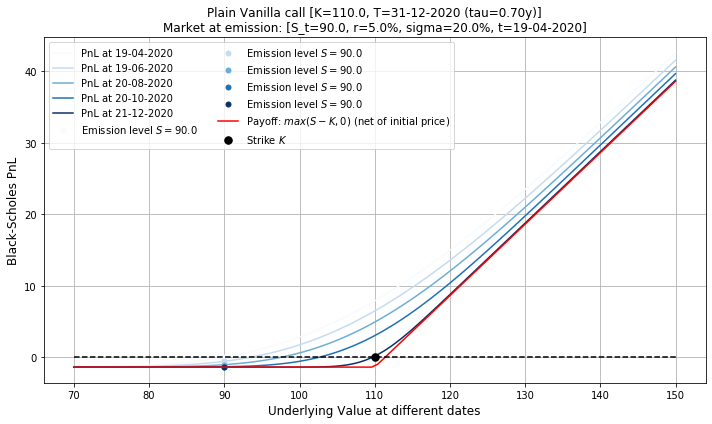

In [200]:
Vanilla_Call_plotter.plot(t=multiple_datetime_valuation_dates, plot_metrics='PnL') # P&L at multiple dates

Here is the `PortfolioPlotter` class

In [201]:
class PortfolioPlotter(Plotter):
    """
    Plotter class to plot the price/P&L of portfolio of options. Inherits from Plotter base-class.
    It implements a composition with an underlying `Portfolio` object to access portfolio-specific attributes.
    
    Attributes:
    -----------
    
        public attributes inherited from Plotter class
    
    Public Methods:
    --------   
    
        public methods inherited from Plotter class
        
        plot:
            Overridden method. It plots the price/P&L of the portfolio. It uses .__plot_single_time() or 
            .__plot_multi_time() (private) methods depending on whether time_parameter is a single value or an Iterable.

    """
    
    def __init__(self, *args, **kwargs):
        # calling the Plotter initializer
        super(PortfolioPlotter, self).__init__(*args, **kwargs)

    def plot(self, *args, **kwargs):
        """
        Can be called using (underlying, time-parameter, plot-metrics, plot-details), where:

        - underlying can be specified either as the 1st positional argument or as keyboard argument 'S'. 
          It's value can be:
        
            - Empty: option's strike price is used as middle point of the x-axis,
            - A number (e.g. S=100),
            - A List of numbers
            
        - time-parameter can be specified either as the 1st positional argument (if no underlying is specified) or
          as the 2nd positional argument or as keyboard argument 't' or 'tau'. 
          It's value can be:
        
            - Empty: .get_tau() is used,
            - A single (e.g. t='15-05-2020') / Iterable (e.g. pd.date_range) valuation date(s): 
              accepted types are either a 'dd-mm-YYYY' String or a dt.datetime object
            - A single (e.g. tau=0.5) / Iterable time-to-maturity value(s) 
            
        - plot-metrics can be specified as keyboard argument 'plot_metrics'. It's value can be:
        
            - Empty: default value used is 'price'
            - plot_metrics = a String 'method' corresponding to a valid '.method()' implemented by self.fin_inst object  
            
        - plot-details can be specified as keyboard argument 'plot_details'. If True, constituent instruments' details 
          are shown if .__plot_single_time() method is called. It's value can be:
        
            - Empty: default value used is False
            - plot_details = True or False
        """
        
        # argument parsing and plot setup
        x_axis = self.x_axis(*args, **kwargs)
        time_parameter, time_label_parameter = self.time_parameter(*args, **kwargs)
        plot_metrics = self.parse_plot_metrics(**kwargs)

        if is_iterable_not_string(time_parameter):
            self.__plot_multi_time(x_axis, time_parameter, time_label_parameter, plot_metrics)
        else:
            plot_instrument_payoffs = self.parse_plot_details(*args, **kwargs)
            self.__plot_single_time(x_axis, time_parameter, time_label_parameter, plot_metrics, plot_instrument_payoffs)
                    
    def __plot_multi_time(self, S, multiple_times, time_labels, plot_metrics):
        """
        Plot Portfolio values against underlying value(s), possibly at multiple dates.
        Dates can be specified either as date Strings or time-to-maturity values.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multiple_times))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different date
        for time, time_label in zip(multiple_times, time_labels):
            ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), '-', lw=1.5, 
                    label=plot_metrics + r" at " + time_label)

        # blue dot at original underlying level for reference
        for time, time_label in zip(multiple_times, time_labels):
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), '.', ms=10, 
                    label=r"Emission level $S={:.1f}$".format(S_t))

        # plot the red payoff line for different underlying values
        if not self.fin_inst.is_multi_horizon:
            if plot_metrics == 'PnL':
                ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=r"PnL at maturity")
            else:
                ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=r"Payoff at maturity")
            
        # plot a dot to highlight the strike position and a reference zero line
        strikes = self.fin_inst.get_K()
        ax.plot(strikes, np.zeros_like(strikes), 'k.', ms=15, label="Strikes $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different dates", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
    
    def __plot_single_time(self, S, time, time_label, plot_metrics, plot_instrument_payoffs):
        """
        Plot Portfolio values against underlying value(s) at fixed date. 
        Date can be specified either as date String or time-to-maturity value.
        Optionally, it plots theoretical upper and lower bounds of the price.
        """
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, getattr(self.fin_inst, plot_metrics)(S, time), 'b-', lw=1.5, 
                label=plot_metrics + r" at " + time_label)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, plot_metrics)(S_t, time), 'b.', ms=15, 
                label=r"Emission level $S={:.1f}$".format(S_t))
        
        # plot the red payoff line for different underlying values
        if not self.fin_inst.is_multi_horizon:
            if plot_metrics == 'PnL':
                ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=r"PnL at maturity")
            else:
                ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=r"Payoff at maturity")

        # optionally, plot the instruments details
        if plot_instrument_payoffs:
            
            # set a color cycle according to the number of instruments in portfolio
            number_of_instruments = len(self.fin_inst.get_composition())
            plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdYlGn(np.linspace(0,1,number_of_instruments)))
            
            for inst in self.fin_inst.get_composition():
                position = inst["position"]
                
                # price or P&L at current time
                if self.fin_inst.is_multi_horizon:
                    
                    ax.plot(S, position * getattr(inst["instrument"], plot_metrics)(S, time), '--', lw=1.5, 
                        label=plot_metrics + r" " + inst["info"] + r" at " + time_label)
                    
                # payoffs or at-maturity P&L
                else:

                    if plot_metrics == 'PnL':
                        ax.plot(S, position * inst["instrument"].PnL(S, tau=0.0), '--',  lw=1.5, 
                                label=inst["info"] + r" PnL at maturity")
                    else:
                        ax.plot(S, position * inst["instrument"].payoff(S), '--',  lw=1.5, 
                                label=inst["info"] + r" payoff at maturity")
                
        # plot a dot to highlight the strike position and a reference zero line
        strikes = self.fin_inst.get_K()
        ax.plot(strikes, np.zeros_like(strikes), 'k.', ms=15, label="Strikes $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at " + time_label, fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(plot_metrics), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

Notice the only difference between `OptionPlotter` and `PortfolioPlotter` is the different meaning of `plot_details` keyword argument: here it activates/deactivates the plotting of constituent instrument-specific reference lines (line 157):

- prices/P&L at current valuation date if `.is_multi_horizon` portfolio,
- payoff/at-maturity P&L otherwise.

In [202]:
dummy_ptf_plotter = PortfolioPlotter(dummy_ptf)

Calling the Plotter initializer!


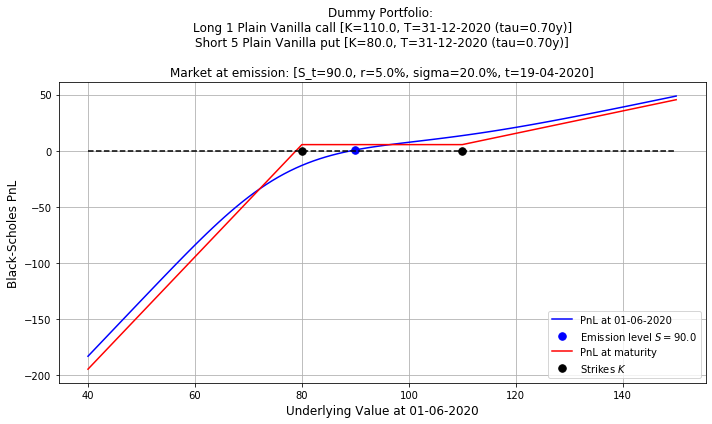

In [203]:
dummy_ptf_plotter.plot(t='01-06-2020', plot_metrics='PnL') # dummy portfolio value at single date

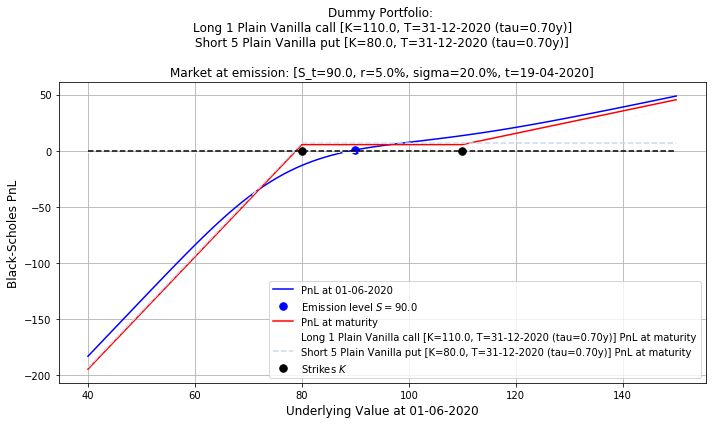

In [204]:
# dummy portfolio value at single date - with instruments payoffs
dummy_ptf_plotter.plot(t='01-06-2020', plot_metrics='PnL', plot_details=True) 

# 4. Option Strategies <a name="opt_strat"></a>

We now apply the `PortfolioPlotter` class to plot some relevant option strategies.

## 4.1. Short positions on options <a name="short_positions"></a>

Let's visualize a simple option strategy: a short position on a plain-vanilla put option.

In [205]:
Vanilla_Put = PlainVanillaOption(market_env, option_type='put')
Vanilla_Put

Initializing the EuropeanOption!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [206]:
short_put_ptf = Portfolio()
short_put_ptf.add_instrument(Vanilla_Put, -1)
short_put_ptf

Dummy Portfolio: 
Short 1 Plain Vanilla put [K=100.0, T=31-12-2020 (tau=0.70y)]

In [207]:
short_put_ptf_plotter = PortfolioPlotter(short_put_ptf)

Calling the Plotter initializer!


Here is the value of the short position

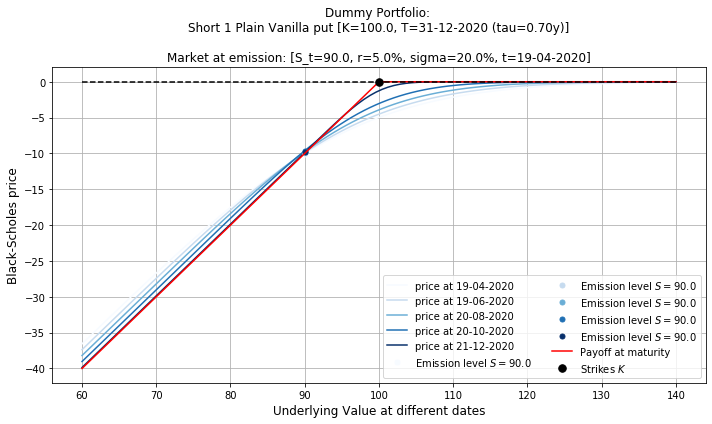

In [208]:
short_put_ptf_plotter.plot(t=multiple_datetime_valuation_dates) # short-Put position value at multiple dates

The red line represents the payoff of the position: negative if the option is exercised at maturity (since we are selling the option), null otherwise.


The blue lines represent the negative value of the position at different valuation dates. You can think of each blue line as the amount of money needed to close the position on a given date. To close the short position we need to buy (aka _going long_ ) another put with same strike price and same expiration date of the one we sold.

Here is the P&L generated by the position

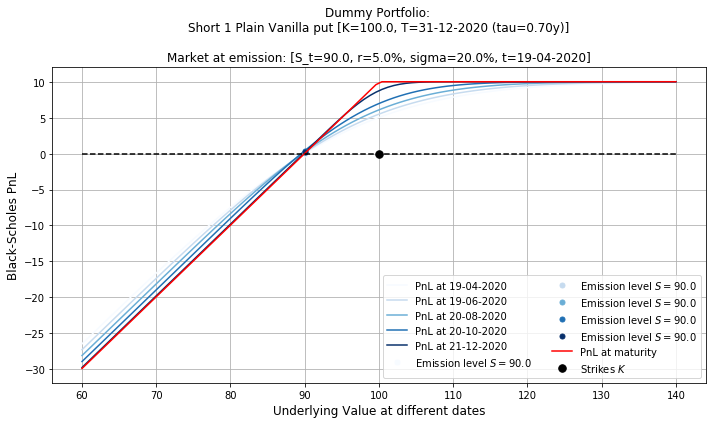

In [209]:
# short-Put position P&L at multiple dates
short_put_ptf_plotter.plot(t=multiple_datetime_valuation_dates, plot_metrics='PnL')

In [210]:
p_t = Vanilla_Put.get_initial_price()
p_t

10.041330587465126

In [211]:
K = Vanilla_Put.get_K()
K

100.0

In [212]:
K - p_t

89.95866941253487

As we see, the put gets exercised at maturity ($T=$ December 31st, 2020) if $S_T < K = \$100$. At maturity, it generates a profit if the initial payment $p_t \approx \$ 10.04$ received when the put is sold on date April 19th, 2020 is not offset by the payoff $K-S_T = \$100 - S_T$ to be granted to owner of the option if he/she exercises the option at expiration $T$. 

That is, the P&L of the short-put position at maturity is  

$$
P\&L_T(S) = \mbox{payoff}(S) - p_t \approx \max (\$100 - S, 0) - \$ 10.04 > 0 \mbox{ if and only if } S > \$100 - p_t \approx \$ 89.96
$$

Recall that we are deliberately neglecting the time value of money.

We can verify this testing whether the short-put P&L at maturity is exactly zero at $S=K-p_t$

In [213]:
expiration_date = Vanilla_Put.get_T()
expiration_date

datetime.datetime(2020, 12, 31, 0, 0)

In [214]:
short_put_ptf.PnL(S=K-p_t, t=expiration_date)

-0.0

## 4.2. Bull Spread <a name="bull_spread"></a>

A _Spread_ is an option strategy involving two plain-vanilla options of the same kind: two (or more than two) calls or puts. A rather popular Spread strategy is the _bull spread,_ which can be implemented:

- buying a call of strike price $K_{long}$;
- selling another call of higher strike price $K_{short} > K_{long}$

Both options are written on the same underlying $S$ and have the same expiration date $T$, that we choose to be Dec 31st, 2021. Let's visualize this strategy using our `Portfolio` class.

In [215]:
K_long = 80
K_short = 110

In [216]:
Vanilla_Call_long = PlainVanillaOption(market_env, K=K_long, T='31-12-2021')
Vanilla_Call_long

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=80.0, t=19-04-2020, T=31-12-2021, tau=1.70y, r=5.0%, sigma=20.0%)

In [217]:
Vanilla_Call_short = PlainVanillaOption(market_env, K=K_short, T='31-12-2021')
Vanilla_Call_short

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2021, tau=1.70y, r=5.0%, sigma=20.0%)

In [218]:
bull_spread_ptf = Portfolio(name="Bull Spread Strategy")
bull_spread_ptf.add_instrument(Vanilla_Call_long, 1)
bull_spread_ptf.add_instrument(Vanilla_Call_short, -1)
bull_spread_ptf

Bull Spread Strategy Portfolio: 
Long 1 Plain Vanilla call [K=80.0, T=31-12-2021 (tau=1.70y)]
Short 1 Plain Vanilla call [K=110.0, T=31-12-2021 (tau=1.70y)]

In [219]:
bull_spread_ptf_plotter = PortfolioPlotter(bull_spread_ptf)

Calling the Plotter initializer!


This is the price profile of the strategy, with the two calls payoffs displayed.

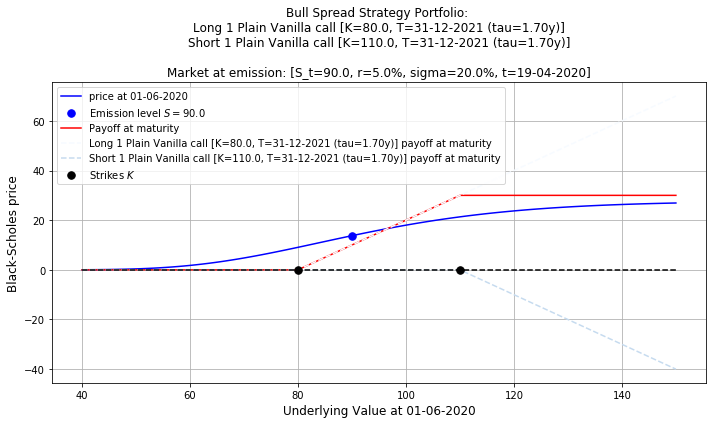

In [220]:
bull_spread_ptf_plotter.plot(t='01-06-2020', plot_details=True)

Let's now visualize the P&L of the strategy

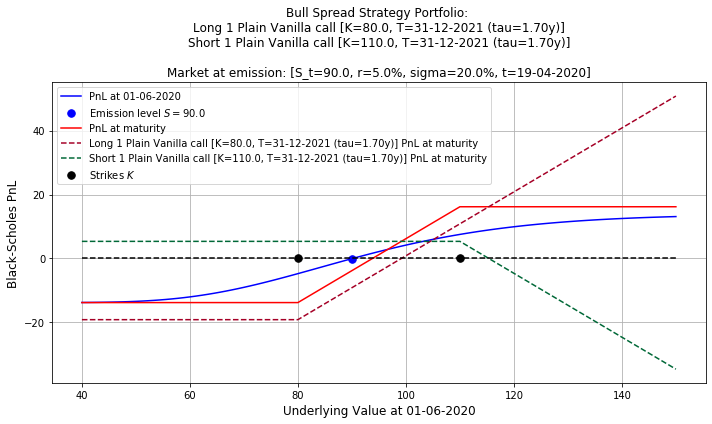

In [221]:
bull_spread_ptf_plotter.plot(t='01-06-2020', plot_metrics="PnL", plot_details=True)

The rationale of a bull spread strategy is an investor owning a $K_{long}$-call, who wants to get rid of some _downside-risk_ in exchange of some _upside potential._ You can see this in plot comparing the at-maturity P&L of the portfolio (continuous red line) with that of the long position in the $K_{long}$-call (red dashed line) and that of the short position in the $K_{short}$-call (green dashed line). The sum of the two dashed P&Ls make the portfolio P&L.

In other words, the owner of the $K_{long}$-call is giving up some potential profits of his/her position in exchange of collecting the premium of selling the $K_{short}$-call, which reduces its loss in case the $K_{long}$-call expires out of the money ($S_T < K_{long} = \$80$, thus not exercised) or not paying enough to offset its initial cost. You can see this observing that the Bull Spread at-maturity P&L is: 

- less negative than the loss of the long position in the $K_{long}$-call in the $S_T < K_{long}$ ($K_{long} \leq S_T < K_{short}$) region - thus limiting the loss, 
- from less negative to slightly more positive than the P&L of the long position in the $K_{long}$-call in the $K_{long} \leq S_T < K_{short}$,
- getting saturated and flat for $S_T \geq K_{short}$ becoming smaller than the profit on the $K_{long}$-call - thus limiting profits - because the $K_{short}$-call gets exercised by the counterparty.

### 4.2.1. Digital Call Option replication using a Bull Spread Strategy <a name="syntetic_digital"></a>

This section is dedicated to my former UBS boss and good friend Fabian Buchmann.

Let's go back to the value of our Bull Spread strategy. We set $K_{long} = \$80$ and $K_{short} = \$110$

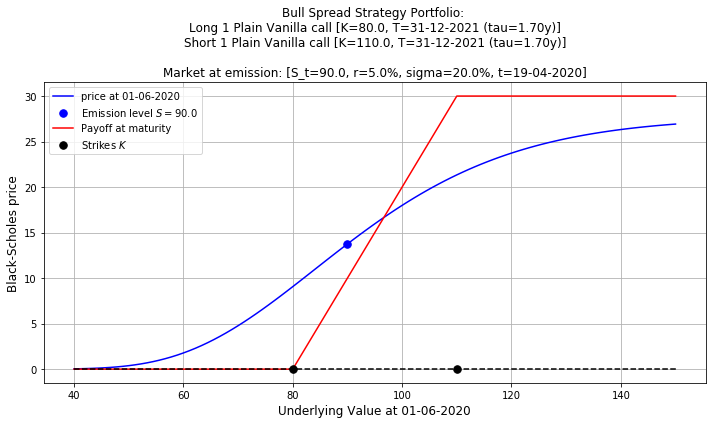

In [222]:
bull_spread_ptf_plotter.plot(t='01-06-2020')

What would happen if we decrease the distance between the two strikes $K_{long}$ and $K_{short}$?

Initializing the EuropeanOption!
Initializing the EuropeanOption!
Calling the Plotter initializer!


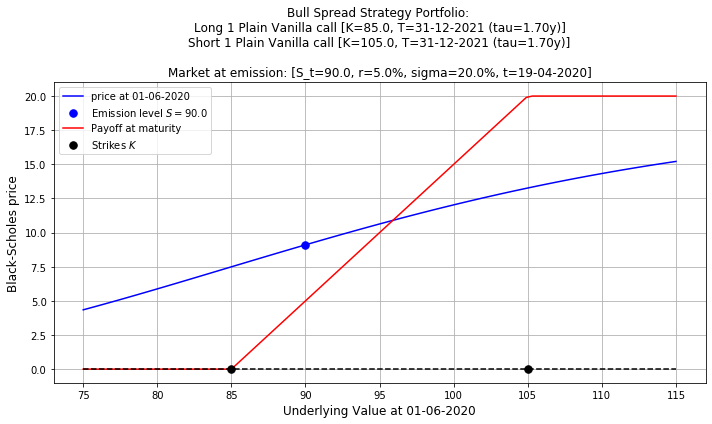

Initializing the EuropeanOption!
Initializing the EuropeanOption!
Calling the Plotter initializer!


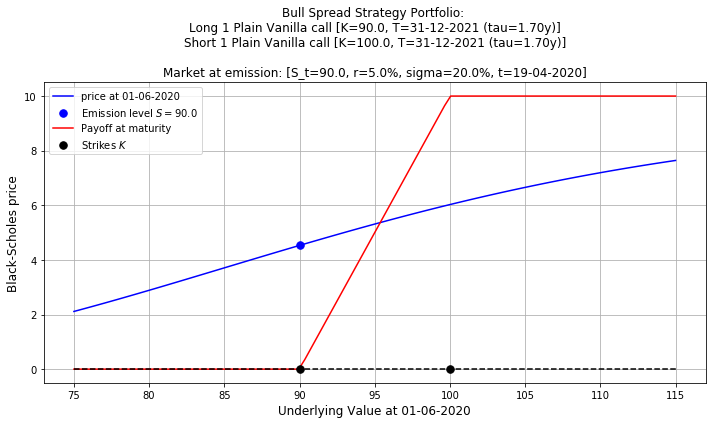

Initializing the EuropeanOption!
Initializing the EuropeanOption!
Calling the Plotter initializer!


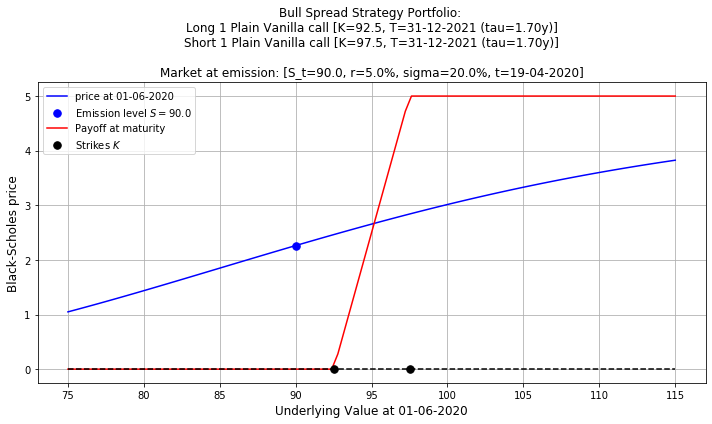

Initializing the EuropeanOption!
Initializing the EuropeanOption!
Calling the Plotter initializer!


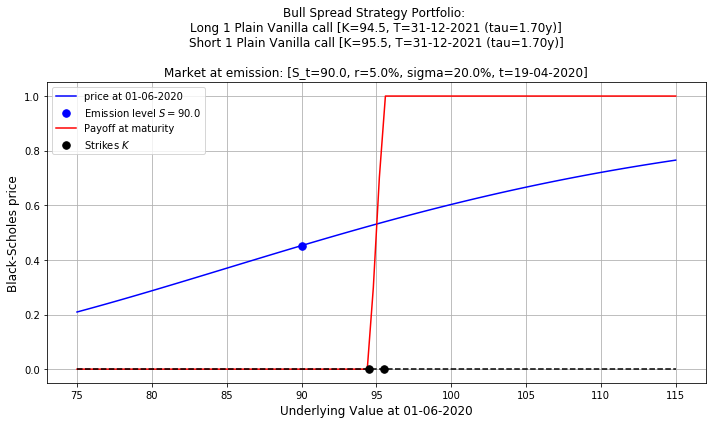

In [223]:
for K_long, K_short in zip([85, 90, 92.5, 94.5], [105, 100, 97.5, 95.5]):

    Vanilla_Call_long = PlainVanillaOption(market_env, K=K_long, T='31-12-2021')
    Vanilla_Call_short = PlainVanillaOption(market_env, K=K_short, T='31-12-2021')

    bull_spread_ptf = Portfolio(name="Bull Spread Strategy")
    bull_spread_ptf.add_instrument(Vanilla_Call_long, 1)
    bull_spread_ptf.add_instrument(Vanilla_Call_short, -1)

    bull_spread_ptf_plotter = PortfolioPlotter(bull_spread_ptf)
    S_middle = 0.5*(K_long + K_short) # middle point of the x-axis
    bull_spread_ptf_plotter.plot(S=S_middle, t='01-06-2020')

Can you recognize something familiar? Observe that:

- qualitatively, the shape of the payoff of the Bull Spread strategy with increasingly near strike prices 

$$
|K_{long} - K_{short}| \rightarrow 0
$$ 

is approaching the discontinuity typical of the payoff of a digital option with strike price 

$$
K = \frac{K_{short} + K_{long}}{2}
$$

- the height of the payoff in the saturated profit region ($S_T > K_{short}$) is always flat at the value $K_{long} - K_{short}$, that is the spread between the two strike prices.

For example, if we take two extremely near strikes, such that 

$$
|K_{long} - K_{short}| = 2 \epsilon = 2 \times 10^{-5}
$$

the height of the profit region will decrease to $2 \epsilon = 0.00002$.

Initializing the EuropeanOption!
Initializing the EuropeanOption!
Calling the Plotter initializer!


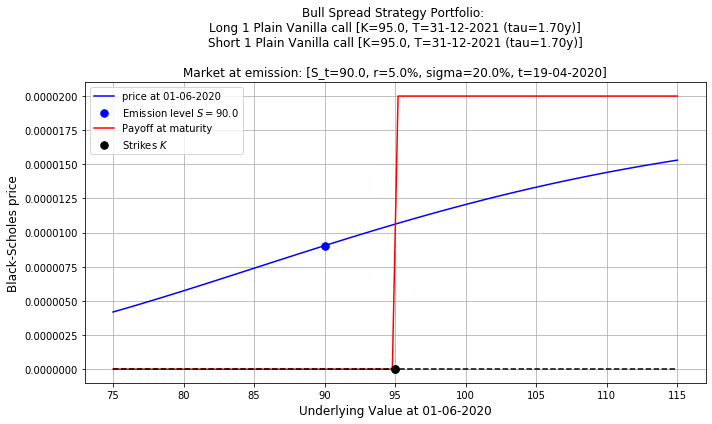

In [224]:
epsilon = 1e-5
K = 95

K_long = K - epsilon
K_short = K + epsilon

Vanilla_Call_long = PlainVanillaOption(market_env, K=K_long, T='31-12-2021')
Vanilla_Call_short = PlainVanillaOption(market_env, K=K_short, T='31-12-2021')

bull_spread_ptf = Portfolio(name="Bull Spread Strategy")
bull_spread_ptf.add_instrument(Vanilla_Call_long, 1)
bull_spread_ptf.add_instrument(Vanilla_Call_short, -1)

bull_spread_ptf_plotter = PortfolioPlotter(bull_spread_ptf)
S_middle = 0.5*(K_long + K_short) # middle point of the x-axis
bull_spread_ptf_plotter.plot(S=S_middle, t='01-06-2020')

If we compare with a cash-or-nothing unitary ($Q=\$1$) digital call with strike $K= (K_{short} + K_{long})/2=(\$110 + \$80)/2 = \$95$

Initializing the EuropeanOption!
Calling the Plotter initializer!


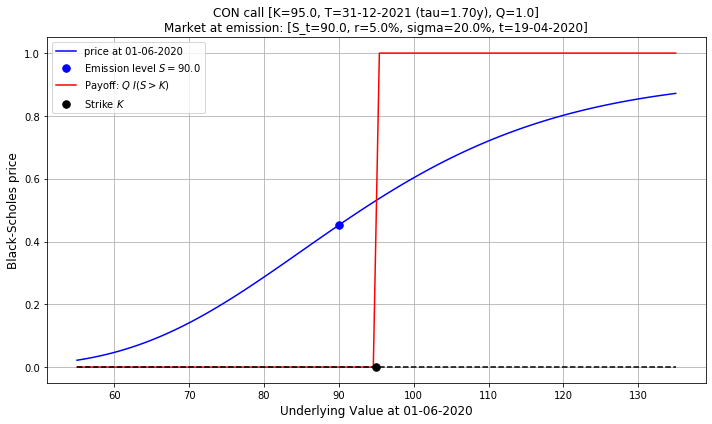

In [225]:
CON_Call = DigitalOption(market_env, K=95, T='31-12-2021')

CON_Call_plotter = OptionPlotter(CON_Call)

CON_Call_plotter.plot(t='01-06-2020')

we see that, in order to make a precise replication, we need to scale-up the positions of the Bull Spread too. This in order to increase the height of the profit region from $2 \epsilon$ to $1$. Before reading further, think about it: how many call contracts should we buy and sell in our replicating Bull Strategy in order to achieve this increase?

In general, a Digital cash-or-nothing unitary ($Q=\$1$) call option with strike $K$ and maturity $T$, can be replicated (has same price, P&L, etc.. it's effectively identical) by a Bull Spread strategy involving:

- A long position on $\frac{1}{2 \epsilon}$ call contracts of strike $K_{long} = K-\epsilon$;
- A short position on $\frac{1}{2 \epsilon}$ call contracts of strike $K_{short} = K+\epsilon$;

in the limit of $\epsilon \rightarrow 0$. In practice, a small but finite $\epsilon$ is chosen (e.g. $\epsilon \approx 10^{-5}$, depending on the needed precision)

Let's visualize this replicating Bull Spread Strategy

Initializing the EuropeanOption!
Initializing the EuropeanOption!
Calling the Plotter initializer!


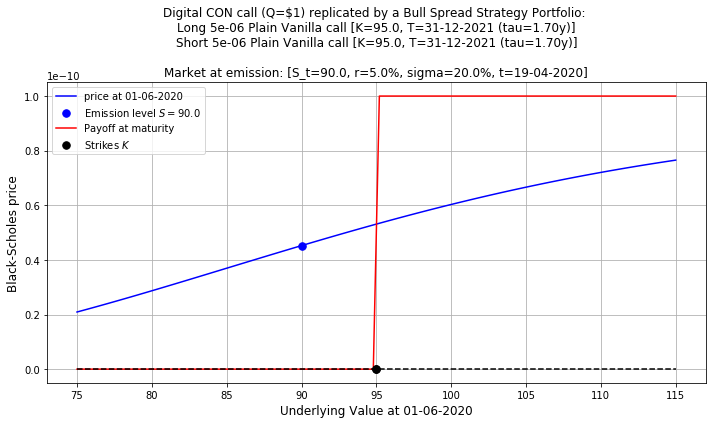

In [226]:
epsilon = 1e-5
K = 95

K_long = K - epsilon
K_short = K + epsilon

Vanilla_Call_long = PlainVanillaOption(market_env, K=K_long, T='31-12-2021')
Vanilla_Call_short = PlainVanillaOption(market_env, K=K_short, T='31-12-2021')

bull_spread_ptf = Portfolio(name="Digital CON call (Q=\$1) replicated by a Bull Spread Strategy")

scaled_position = 0.5*epsilon

bull_spread_ptf.add_instrument(Vanilla_Call_long, scaled_position) # notice from 1 to 1/2*eps
bull_spread_ptf.add_instrument(Vanilla_Call_short, -scaled_position) # notice from -1 to -1/2*eps 

bull_spread_ptf_plotter = PortfolioPlotter(bull_spread_ptf)
S_middle = 0.5*(K_long + K_short) # middle point of the x-axis
bull_spread_ptf_plotter.plot(S=S_middle, t='01-06-2020')

This is how Digital options - having a discountinuous payoff - are actually represented in computing systems, which can manage with relative more ease continuous payoffs, such as those of plain-vanilla options.

## 4.3. Straddle <a name="straddle"></a>

A _Combination_ is an option strategy involving plain-vanilla options (calls and put) written on the same underlying $S$. A rather popular Combination strategy is the _straddle,_ which can be implemented:

- buying a call and put written on the same underlying $S$ and have the same strike $K$ and expiration date $T$

We choose the expiration date to be $T=$ Dec 31st, 2021. Let's visualize this strategy using our `Portfolio` class.

In [227]:
Vanilla_Call = PlainVanillaOption(market_env, T='31-12-2021')
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2021, tau=1.70y, r=5.0%, sigma=20.0%)

In [228]:
Vanilla_Put = PlainVanillaOption(market_env, option_type='put', T='31-12-2021')
Vanilla_Put

Initializing the EuropeanOption!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2021, tau=1.70y, r=5.0%, sigma=20.0%)

In [229]:
straddle_ptf = Portfolio(name="Straddle Strategy")
straddle_ptf.add_instrument(Vanilla_Call, 1)
straddle_ptf.add_instrument(Vanilla_Put, 1)
straddle_ptf

Straddle Strategy Portfolio: 
Long 1 Plain Vanilla call [K=100.0, T=31-12-2021 (tau=1.70y)]
Long 1 Plain Vanilla put [K=100.0, T=31-12-2021 (tau=1.70y)]

In [230]:
straddle_ptf_plotter = PortfolioPlotter(straddle_ptf)

Calling the Plotter initializer!


This is the price profile of the strategy, with the two option payoffs displayed.

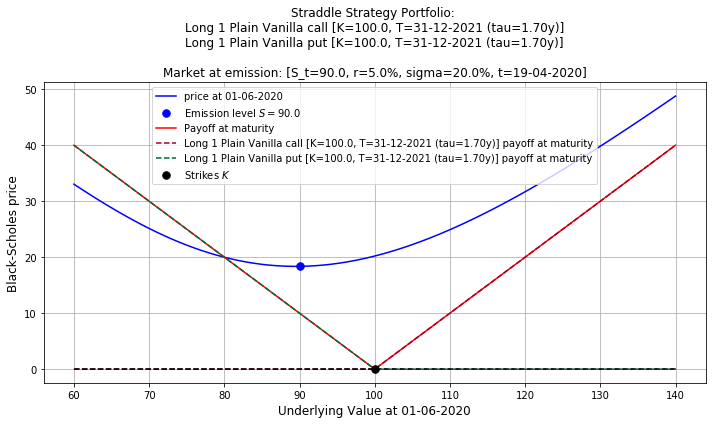

In [231]:
straddle_ptf_plotter.plot(t='01-06-2020', plot_details=True)

Let's now visualize the P&L of the strategy, that is also known as _bottom straddle_

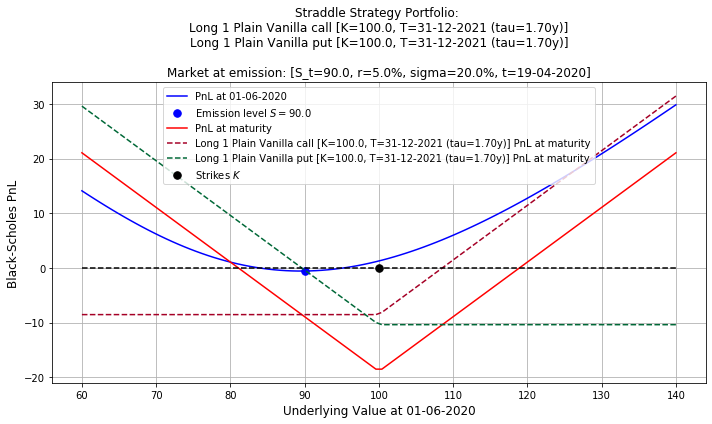

In [232]:
straddle_ptf_plotter.plot(t='01-06-2020', plot_metrics="PnL", plot_details=True)

Straddles are strategies reflecting investor's expectation of a great underlying price variation, but unknown direction.

## 4.4. Calendar Spread <a name="calendar_spread"></a>

A _calendar spread_ is another version of a the general _Spread_ strategy involving two plain-vanilla calls or puts as follow:

- selling a call/put of expiration date $T_{short}$;
- buying a call/put of expiration date $T_{long} > T_{short}$;

Both options are written on the same underlying $S$ and have the same strike price $K$. Let's visualize this strategy using our `Portfolio` class. We shall use call options.

In [233]:
T_short = "31-05-2020"
T_long = "30-08-2020"

We consider a so-called _neutral_ calendar spread in which the options are chosen to have a common strike price $K$ similar to the current underlying value $S_t$

In [234]:
S_t = market_env.get_S()

In [235]:
Vanilla_Call_short = PlainVanillaOption(market_env, T=T_short, K=S_t)
Vanilla_Call_short

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=90.0, t=19-04-2020, T=31-05-2020, tau=0.12y, r=5.0%, sigma=20.0%)

In [236]:
Vanilla_Call_long = PlainVanillaOption(market_env, T=T_long, K=S_t)
Vanilla_Call_long

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=90.0, t=19-04-2020, T=30-08-2020, tau=0.36y, r=5.0%, sigma=20.0%)

In [237]:
calendar_spread_ptf = Portfolio(name="Calendar Spread Strategy")
calendar_spread_ptf.add_instrument(Vanilla_Call_short, -1)
calendar_spread_ptf.add_instrument(Vanilla_Call_long, 1)
calendar_spread_ptf

Calendar Spread Strategy Portfolio: 
Short 1 Plain Vanilla call [K=90.0, T=31-05-2020 (tau=0.12y)]
Long 1 Plain Vanilla call [K=90.0, T=30-08-2020 (tau=0.36y)]

In [238]:
calendar_spread_ptf_plotter = PortfolioPlotter(calendar_spread_ptf)

Calling the Plotter initializer!


This is the price profile of the strategy, with the two calls payoffs displayed.

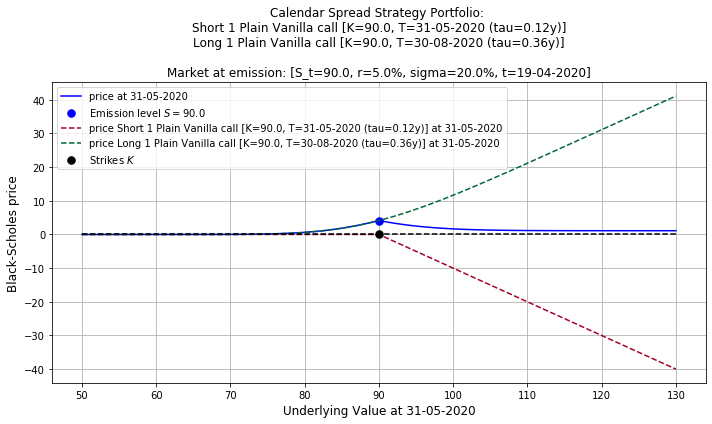

In [239]:
calendar_spread_ptf_plotter.plot(t=T_short, plot_details=True)

Let's now visualize the P&L of the strategy at the nearest maturity $T_{short}$, when the $T_{short}$-call is possibly exercised by the owner (recall that we are short the $T_{short}$-call). Moreover, we assume that the long position in the $T_{long}$-call - maturing at $T_{long} > T_{short}$ - is closed in advance at $T_{short}$. Recall that closing the long position on the $T_{long}$-call means selling an identical $T_{long}$-call.

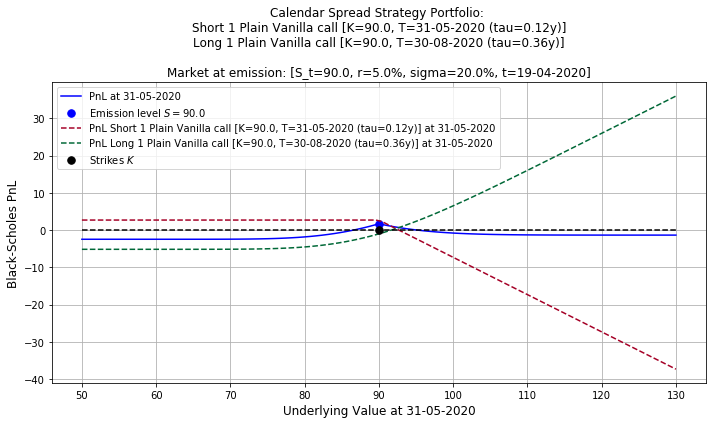

In [240]:
calendar_spread_ptf_plotter.plot(t=T_short, plot_metrics="PnL", plot_details=True)

As you can see from the plot, the P&L of the calendar spread at $T_{short}=$ May 31st, 2020 (blue line), is given by the sum of:

- (red-dashed line) line the at maturity P&L (payoff - initial price) of the expiring $T_{short}$-call;
- (green-dashed line) line the P&L (closing price - initial price) of the closed $T_{long}$-call;

The calendar spread generates a profit if the underlying value at the nearest maturity $T_{short}$ - when the $T_{short}$-call expires, the $T_{long}$-call is closed and the strategy thus ends - settles at a value near the strike price 

$$
S_{T_{short}} \approx K
$$ 

and a loss if $S_{T_{short}}$ is significantly far from $K$ (greater or smaller than that). 